<a href="https://colab.research.google.com/github/neetushibu/IontheFold-Team6/blob/main/IonTheFold003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ESM2 ABPS (trained) - Worse performance than ProteinMPNN

In [ ]:
# -*- coding: utf-8 -*-
"""Complete Enhanced ProteinMPNN with Working Training - Single File Solution"""

#@title Cell 1: Install Dependencies
import subprocess
import sys

def install_packages():
    """Install required packages"""
    core_packages = ['biopython', 'matplotlib', 'pandas', 'scipy', 'fair-esm']

    for package in core_packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
            print(f"✅ Installed {package}")
        except Exception as e:
            print(f"⚠️ Failed to install {package}: {e}")

    try:
        subprocess.check_call(['apt-get', 'update', '-qq'])
        subprocess.check_call(['apt-get', 'install', '-y', '-qq', 'apbs'])
        print("✅ APBS installed")
    except:
        print("⚠️ APBS install failed, using fallback")

install_packages()

#@title Cell 2: Import Libraries
import json, time, os, sys, glob, subprocess, warnings
warnings.filterwarnings('ignore')

if not os.path.isdir("ProteinMPNN"):
    os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
sys.path.append('/content/ProteinMPNN')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import copy
import random
from scipy import stats
from collections import defaultdict, Counter
import re

try:
    from Bio import PDB
    from Bio.PDB import PDBParser
    from scipy.spatial.distance import cdist
    BIO_AVAILABLE = True
    print("✅ Bio/PDB imports successful")
except Exception as e:
    print(f"⚠️ Bio imports failed: {e}")
    BIO_AVAILABLE = False

try:
    import esm
    ESM_AVAILABLE = True
    print("✅ ESM-2 library imported successfully!")
except Exception as e:
    print(f"⚠️ ESM-2 library not available: {e}")
    ESM_AVAILABLE = False

from protein_mpnn_utils import (
    loss_nll, loss_smoothed, gather_edges, gather_nodes,
    gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq,
    tied_featurize, parse_PDB, StructureDataset,
    StructureDatasetPDB, ProteinMPNN
)

print("✅ All libraries imported successfully!")

#@title Cell 3: APBS Electrostatic Handler
class APBSElectrostaticHandler:
    """Handles APBS electrostatic potential calculations"""

    def __init__(self, use_simplified=True):
        self.use_simplified = use_simplified
        self.apbs_available = self._check_apbs_availability()
        self.electrostatic_cache = {}

    def _check_apbs_availability(self):
        """Check if APBS is available"""
        try:
            result = subprocess.run(['apbs', '--version'],
                                  capture_output=True, text=True, timeout=10)
            if result.returncode == 0:
                print("✅ APBS found and working!")
                return True
        except:
            pass
        print("⚠️ APBS not available, using simplified calculation")
        return False

    def calculate_simplified_electrostatics(self, pdb_path, chain_ids):
        """Simplified electrostatic calculation"""
        if not BIO_AVAILABLE:
            print("⚠️ BioPython not available, using dummy features")
            return np.array([0.0]), [{'chain': 'A', 'resnum': 1, 'resname': 'ALA', 'charge': 0, 'position': np.array([0,0,0])}]

        try:
            parser = PDBParser(QUIET=True)
            structure = parser.get_structure('protein', pdb_path)

            charge_map = {
                'ARG': +1, 'LYS': +1, 'HIS': +0.5,
                'ASP': -1, 'GLU': -1,
                'SER': 0, 'THR': 0, 'ASN': 0, 'GLN': 0,
                'CYS': 0, 'TYR': 0, 'TRP': 0,
                'ALA': 0, 'VAL': 0, 'ILE': 0, 'LEU': 0, 'MET': 0,
                'PHE': 0, 'PRO': 0, 'GLY': 0
            }

            all_positions = []
            all_charges = []
            residue_info = []

            for model in structure:
                for chain in model:
                    if chain.id in chain_ids:
                        for residue in chain:
                            if residue.get_id()[0] == ' ':
                                resname = residue.get_resname()
                                charge = charge_map.get(resname, 0)

                                if 'CA' in residue:
                                    ca_atom = residue['CA']
                                    pos = ca_atom.get_coord()
                                    all_positions.append(pos)
                                    all_charges.append(charge)
                                    residue_info.append({
                                        'chain': chain.id,
                                        'resnum': residue.get_id()[1],
                                        'resname': resname,
                                        'charge': charge,
                                        'position': pos
                                    })

            if not all_positions:
                return None, None

            positions = np.array(all_positions)
            charges = np.array(all_charges)

            potentials = []
            for i, pos in enumerate(positions):
                potential = 0.0
                for j, other_pos in enumerate(positions):
                    if i != j:
                        distance = np.linalg.norm(pos - other_pos)
                        if distance > 0.1:
                            potential += charges[j] / distance
                potentials.append(potential)

            potentials = np.array(potentials)

            if len(potentials) > 1:
                potentials = (potentials - np.mean(potentials)) / (np.std(potentials) + 1e-8)

            print(f"✅ Calculated electrostatic potentials for {len(potentials)} residues")
            return potentials, residue_info

        except Exception as e:
            print(f"❌ Electrostatics calculation failed: {e}")
            return None, None

    def get_electrostatic_features(self, pdb_path, chain_ids, sequence_length):
        """Get electrostatic features tensor"""
        cache_key = f"{pdb_path}_{'-'.join(sorted(chain_ids))}"

        if cache_key in self.electrostatic_cache:
            potentials, residue_info = self.electrostatic_cache[cache_key]
        else:
            potentials, residue_info = self.calculate_simplified_electrostatics(pdb_path, chain_ids)
            self.electrostatic_cache[cache_key] = (potentials, residue_info)

        if potentials is None:
            return torch.zeros(sequence_length, 4)

        features = []
        charges = np.array([info['charge'] for info in residue_info])
        positions = np.array([info['position'] for info in residue_info])

        for i in range(len(potentials)):
            potential = potentials[i]
            charge = charges[i]

            charged_indices = np.where(np.abs(charges) > 0)[0]
            if len(charged_indices) > 0:
                if i in charged_indices:
                    other_charged = charged_indices[charged_indices != i]
                    if len(other_charged) > 0:
                        distances = np.linalg.norm(positions[other_charged] - positions[i], axis=1)
                        min_charge_dist = np.min(distances)
                    else:
                        min_charge_dist = 100.0
                else:
                    distances = np.linalg.norm(positions[charged_indices] - positions[i], axis=1)
                    min_charge_dist = np.min(distances)
            else:
                min_charge_dist = 100.0

            local_distances = np.linalg.norm(positions - positions[i], axis=1)
            local_mask = local_distances < 10.0
            local_charge_density = np.sum(np.abs(charges[local_mask]))

            features.append([potential, charge, min_charge_dist, local_charge_density])

        features = np.array(features)

        if len(features) < sequence_length:
            padding = np.zeros((sequence_length - len(features), 4))
            features = np.vstack([features, padding])
        elif len(features) > sequence_length:
            features = features[:sequence_length]

        for col in range(features.shape[1]):
            col_data = features[:, col]
            if np.std(col_data) > 1e-8:
                features[:, col] = (col_data - np.mean(col_data)) / np.std(col_data)

        return torch.tensor(features, dtype=torch.float32)

#@title Cell 4: Enhanced ESM-2 Handler
class EnhancedESM2Handler:
    """Enhanced ESM-2 handler with APBS integration"""

    def __init__(self):
        self.esm2_model = None
        self.alphabet = None
        self.available = False
        self.device = torch.device("cpu")
        self.apbs_handler = APBSElectrostaticHandler()

    def load_esm2(self):
        """Load ESM-2 model"""
        if not ESM_AVAILABLE:
            print("⚠️ ESM-2 not available")
            return False

        try:
            print("🔥 Loading ESM-2 model...")
            self.esm2_model, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
            self.esm2_model = self.esm2_model.to(self.device)
            self.esm2_model.eval()

            if self._test_esm2():
                self.available = True
                print("✅ ESM-2 loaded successfully!")
                return True
            else:
                print("⚠️ ESM-2 test failed")
                return False

        except Exception as e:
            print(f"❌ Failed to load ESM-2: {e}")
            return False

    def _test_esm2(self):
        """Test ESM-2"""
        try:
            test_seq = "ACDEFGHIKLMNPQRSTVWY"
            tokens = self.alphabet.encode(test_seq)
            batch_tokens = torch.tensor([tokens]).to(self.device)

            with torch.no_grad():
                results = self.esm2_model(batch_tokens, repr_layers=[33])
                embeddings = results["representations"][33]

            seq_embeddings = embeddings[0, 1:-1, :]
            print(f"✅ ESM-2 test passed: {seq_embeddings.shape}")
            return True

        except Exception as e:
            print(f"❌ ESM-2 test failed: {e}")
            return False

    def get_enhanced_embeddings(self, sequences_batch, pdb_path, chain_ids, target_device=None):
        """Generate ESM-2 + APBS enhanced embeddings"""
        if not self.available:
            batch_size = len(sequences_batch)
            seq_len = max(len(seq) for seq in sequences_batch) if sequences_batch else 100
            device = target_device if target_device else self.device
            return torch.zeros(batch_size, seq_len, 1284, device=device)

        try:
            amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
            batch_embeddings = []
            max_seq_len = max(len(seq) for seq in sequences_batch) if sequences_batch else 100

            electrostatic_features = self.apbs_handler.get_electrostatic_features(
                pdb_path, chain_ids, max_seq_len
            )

            for seq_indices in sequences_batch:
                seq_str = ""
                if isinstance(seq_indices, torch.Tensor):
                    indices = seq_indices.cpu().numpy()
                else:
                    indices = seq_indices

                for idx in indices:
                    if isinstance(idx, (int, np.integer)) and 0 <= idx < len(amino_acids):
                        seq_str += amino_acids[int(idx)]
                    else:
                        seq_str += "A"

                if len(seq_str) > 500:
                    seq_str = seq_str[:500]

                tokens = self.alphabet.encode(seq_str)
                batch_tokens = torch.tensor([tokens], device=self.device)

                with torch.no_grad():
                    results = self.esm2_model(batch_tokens, repr_layers=[33])
                    embeddings = results["representations"][33]
                    seq_embeddings = embeddings[0, 1:-1, :]

                batch_embeddings.append(seq_embeddings)

            if not batch_embeddings:
                device = target_device if target_device else self.device
                return torch.zeros(1, max_seq_len, 1284, device=device)

            max_len = max(emb.shape[0] for emb in batch_embeddings)
            padded_embeddings = []

            for emb in batch_embeddings:
                if emb.shape[0] < max_len:
                    padding = torch.zeros(max_len - emb.shape[0], 1280, device=self.device)
                    padded_emb = torch.cat([emb, padding], dim=0)
                else:
                    padded_emb = emb[:max_len]
                padded_embeddings.append(padded_emb)

            esm2_result = torch.stack(padded_embeddings)

            if electrostatic_features.shape[0] != max_len:
                if electrostatic_features.shape[0] < max_len:
                    padding = torch.zeros(max_len - electrostatic_features.shape[0], 4)
                    electrostatic_features = torch.cat([electrostatic_features, padding], dim=0)
                else:
                    electrostatic_features = electrostatic_features[:max_len]

            batch_size = esm2_result.shape[0]
            electrostatic_batch = electrostatic_features.unsqueeze(0).repeat(batch_size, 1, 1)
            electrostatic_batch = electrostatic_batch.to(esm2_result.device)

            enhanced_embeddings = torch.cat([esm2_result, electrostatic_batch], dim=-1)

            if target_device and target_device != self.device:
                enhanced_embeddings = enhanced_embeddings.to(target_device)

            print(f"✅ Enhanced embeddings: {enhanced_embeddings.shape}")
            return enhanced_embeddings

        except Exception as e:
            print(f"⚠️ Enhanced embedding failed: {e}")
            batch_size = len(sequences_batch) if sequences_batch else 1
            device = target_device if target_device else self.device
            return torch.zeros(batch_size, 100, 1284, device=device)

#@title Cell 5: Safe ProteinMPNN Base Classes
class SafeProteinMPNN(ProteinMPNN):
    """Safe wrapper that fixes tensor dtype issues"""

    def forward(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                use_input_decoding_order=False, decoding_order=None):
        residue_idx = residue_idx.long()
        S = S.long()

        if isinstance(chain_encoding_all, torch.Tensor):
            chain_encoding_all = chain_encoding_all.long()

        return super().forward(X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                             use_input_decoding_order, decoding_order)

class UltraSafeEnhancedProteinMPNN(SafeProteinMPNN):
    """Ultra-safe enhanced version with electrostatic features"""

    def __init__(self, enhanced_esm2_handler, pdb_path=None, chain_ids=None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.enhanced_esm2_handler = enhanced_esm2_handler
        self.pdb_path = pdb_path
        self.chain_ids = chain_ids or []
        self.use_enhanced_features = enhanced_esm2_handler.available
        self.enhancement_weight = nn.Parameter(torch.tensor(0.1))

        print(f"✅ Ultra-Safe Enhanced ProteinMPNN initialized")

    def forward(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                use_input_decoding_order=False, decoding_order=None):

        log_probs = super().forward(X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                                   use_input_decoding_order, decoding_order)

        if self.use_enhanced_features and self.pdb_path is not None:
            try:
                seq_len = S.shape[1]
                electrostatic_features = self.enhanced_esm2_handler.apbs_handler.get_electrostatic_features(
                    self.pdb_path, self.chain_ids, seq_len
                )

                if electrostatic_features.shape[0] == seq_len:
                    electrostatic_features = electrostatic_features.to(log_probs.device)
                    potential = electrostatic_features[:, 0]

                    aa_bias = torch.zeros_like(log_probs)

                    for i in range(seq_len):
                        pot_val = potential[i].item()
                        if abs(pot_val) > 0.5:
                            for aa_idx in [3, 4, 11, 15]:
                                aa_bias[0, i, aa_idx] += pot_val * 0.05

                    enhancement = torch.sigmoid(self.enhancement_weight)
                    log_probs = log_probs + enhancement * aa_bias

            except Exception as e:
                print(f"⚠️ Enhancement failed: {e}")

        return log_probs

#@title Cell 6: Trainable Enhanced Model
class TrainableUltraSafeEnhancedProteinMPNN(UltraSafeEnhancedProteinMPNN):
    """Trainable version with learnable parameters"""

    def __init__(self, enhanced_esm2_handler, pdb_path=None, chain_ids=None, *args, **kwargs):
        super().__init__(enhanced_esm2_handler, pdb_path, chain_ids, *args, **kwargs)

        # Higher initial enhancement weight
        self.enhancement_weight = nn.Parameter(torch.tensor(0.3))

        # Learnable bias for charged residues
        charged_bias = torch.zeros(21)
        charged_bias[[3, 4, 8, 11, 15]] = 0.2  # D, E, H, K, R
        self.charged_bias = nn.Parameter(charged_bias)

        print(f"✅ Trainable Enhanced ProteinMPNN initialized with 30% integration")

    def forward(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                use_input_decoding_order=False, decoding_order=None):

        log_probs = SafeProteinMPNN.forward(self, X, S, mask, chain_M, residue_idx,
                                           chain_encoding_all, randn, use_input_decoding_order,
                                           decoding_order)

        if self.use_enhanced_features and self.pdb_path is not None:
            try:
                seq_len = S.shape[1]
                electrostatic_features = self.enhanced_esm2_handler.apbs_handler.get_electrostatic_features(
                    self.pdb_path, self.chain_ids, seq_len
                )

                if electrostatic_features.shape[0] == seq_len:
                    electrostatic_features = electrostatic_features.to(log_probs.device)
                    potential = electrostatic_features[:, 0]
                    charge = electrostatic_features[:, 1]

                    aa_bias = torch.zeros_like(log_probs)

                    for i in range(seq_len):
                        pot_val = potential[i].item()
                        charge_val = charge[i].item()

                        if abs(pot_val) > 0.3:
                            for aa_idx in [3, 4, 11, 15]:
                                aa_bias[0, i, aa_idx] += pot_val * 0.1

                        aa_bias[0, i] += self.charged_bias

                    enhancement = torch.sigmoid(self.enhancement_weight)
                    enhanced_log_probs = log_probs + enhancement * aa_bias

                    return enhanced_log_probs

            except Exception as e:
                print(f"⚠️ Enhancement failed: {e}")

        return log_probs

class ChargedResidueLoss(nn.Module):
    """Loss function focused on charged residue accuracy"""

    def __init__(self, charged_weight=3.0):
        super().__init__()
        self.charged_weight = charged_weight
        self.charged_indices = torch.tensor([3, 4, 8, 11, 15])

    def forward(self, log_probs, S_target, mask):
        flat_log_probs = log_probs.view(-1, log_probs.size(-1))
        flat_targets = S_target.view(-1)
        flat_mask = mask.view(-1)

        nll_loss = F.nll_loss(flat_log_probs, flat_targets, reduction='none')

        charged_mask = torch.zeros_like(flat_targets, dtype=torch.bool)
        for idx in self.charged_indices.to(flat_targets.device):
            charged_mask |= (flat_targets == idx)

        loss_weights = torch.where(
            charged_mask,
            torch.tensor(self.charged_weight, device=flat_targets.device),
            torch.tensor(1.0, device=flat_targets.device)
        )

        weighted_loss = nll_loss * loss_weights * flat_mask
        return weighted_loss.sum() / flat_mask.sum()

#@title Cell 7: Device Setup and Model Loading
def get_safe_device():
    """Get safe device"""
    if torch.cuda.is_available():
        try:
            test_tensor = torch.tensor([1.0], device='cuda')
            test_result = test_tensor + 1
            return torch.device("cuda:0")
        except:
            print("⚠️ CUDA test failed, using CPU")
            return torch.device("cpu")
    else:
        return torch.device("cpu")

device = get_safe_device()
print(f"Using device: {device}")

# Initialize handlers
enhanced_esm2_handler = EnhancedESM2Handler()
esm2_loaded = enhanced_esm2_handler.load_esm2()

# Load models
model_name = "v_48_020"
backbone_noise = 0.00
path_to_model_weights = '/content/ProteinMPNN/vanilla_model_weights'
hidden_dim = 128
num_layers = 3

model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

standard_model = None
enhanced_model = None

try:
    print("🔥 Loading ProteinMPNN checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    print('Number of edges:', checkpoint['num_edges'])

    # Standard model
    standard_model = ProteinMPNN(
        num_letters=21,
        node_features=hidden_dim,
        edge_features=hidden_dim,
        hidden_dim=hidden_dim,
        num_encoder_layers=num_layers,
        num_decoder_layers=num_layers,
        augment_eps=backbone_noise,
        k_neighbors=checkpoint['num_edges']
    )

    standard_model.load_state_dict(checkpoint['model_state_dict'])
    standard_model = standard_model.to(device)
    standard_model.eval()
    print("✅ Standard ProteinMPNN loaded!")

    # Enhanced model
    if esm2_loaded:
        enhanced_model = TrainableUltraSafeEnhancedProteinMPNN(
            enhanced_esm2_handler=enhanced_esm2_handler,
            pdb_path=None,
            chain_ids=None,
            num_letters=21,
            node_features=hidden_dim,
            edge_features=hidden_dim,
            hidden_dim=hidden_dim,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            augment_eps=backbone_noise,
            k_neighbors=checkpoint['num_edges']
        )

        enhanced_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        enhanced_model = enhanced_model.to(device)
        enhanced_model.eval()
        print("✅ Trainable Enhanced ProteinMPNN loaded!")

except Exception as e:
    print(f"❌ Error loading models: {e}")

#@title Cell 8: Helper Functions
def get_pdb_file(pdb_code, dest_dir=".", overwrite=False, allow_upload=True):
    """Download PDB file"""
    import os, urllib.request, gzip, shutil
    from urllib.error import HTTPError, URLError

    code = (pdb_code or "").strip()
    if not code:
        if not allow_upload:
            raise ValueError("pdb_code is empty and uploads are disabled.")
        return None

    code_l = code.lower()
    code_u = code.upper()
    out_path = os.path.join(dest_dir, f"{code_u}.pdb")

    if os.path.exists(out_path) and not overwrite:
        return out_path

    try:
        url1 = f"https://files.rcsb.org/download/{code_l}.pdb"
        urllib.request.urlretrieve(url1, out_path)
        print(f"✅ Downloaded {code_u}")
        return out_path
    except (HTTPError, URLError):
        try:
            subdir = code_l[1:3]
            url2 = f"https://files.rcsb.org/pub/pdb/data/structures/divided/pdb/{subdir}/pdb{code_l}.ent.gz"
            gz_path = os.path.join(dest_dir, f"pdb{code_l}.ent.gz")

            urllib.request.urlretrieve(url2, gz_path)
            with gzip.open(gz_path, "rb") as f_in, open(out_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
            os.remove(gz_path)

            print(f"✅ Downloaded and decompressed {code_u}")
            return out_path
        except Exception as e2:
            if os.path.exists(gz_path):
                try: os.remove(gz_path)
                except: pass
            print(f"❌ Could not download {code_u}: {e2}")
            return None

def calculate_enhanced_metrics(native_seq, designed_seqs, scores, model_type="Standard"):
    """Calculate enhanced metrics"""
    metrics = {
        'sequence_recovery': [],
        'identity': [],
        'score': [],
        'length': [],
        'charged_residue_recovery': [],
        'model_type': []
    }

    native_clean = native_seq.replace('/', '').replace('X', '')
    charged_residues = set('DEKR')

    for designed_seq, score in zip(designed_seqs, scores):
        designed_clean = designed_seq.replace('/', '').replace('X', '')
        length = min(len(native_clean), len(designed_clean))
        if length == 0:
            continue

        identical = sum(1 for a, b in zip(native_clean[:length], designed_clean[:length]) if a == b)
        identity = (identical / length) * 100

        metrics['sequence_recovery'].append(identity)
        metrics['identity'].append(identity)
        metrics['score'].append(float(score))
        metrics['length'].append(length)
        metrics['model_type'].append(model_type)

        native_charged_pos = [i for i, aa in enumerate(native_clean[:length]) if aa in charged_residues]
        if native_charged_pos:
            charged_recovery = sum(1 for pos in native_charged_pos
                                 if pos < len(designed_clean) and designed_clean[pos] in charged_residues)
            charged_recovery_rate = (charged_recovery / len(native_charged_pos)) * 100
        else:
            charged_recovery_rate = 0
        metrics['charged_residue_recovery'].append(charged_recovery_rate)

    return pd.DataFrame(metrics)

#@title Cell 9: Enhanced Processing Function
def enhanced_process_protein_for_training(pdb_code, model, num_sequences=1, temperature=0.1):
    """Modified processing function for training"""

    try:
        pdb_path = get_pdb_file(pdb_code)
        if pdb_path is None:
            return None

        # Default chain configuration
        designed_chains = ['A']
        fixed_chains = ['B'] if pdb_code != '5MKN' else ['B', 'C', 'D']

        chain_list = list(set(designed_chains + fixed_chains))

        # Set model paths
        model.pdb_path = pdb_path
        model.chain_ids = chain_list

        pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
        dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)
        chain_id_dict = {pdb_dict_list[0]['name']: (designed_chains, fixed_chains)}

        for ix, protein in enumerate(dataset_valid):
            batch_clones = [copy.deepcopy(protein)]

            features = tied_featurize(
                batch_clones, device, chain_id_dict, None, None, None, None, None
            )

            (X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list,
             visible_list_list, masked_list_list, masked_chain_length_list_list,
             chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask,
             tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all,
             bias_by_res_all, tied_beta) = features

            randn_1 = torch.randn(chain_M.shape, device=device)

            # Forward pass with loss calculation
            log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)

            # Calculate training loss
            mask_for_loss = mask * chain_M * chain_M_pos

            loss_fn = ChargedResidueLoss(charged_weight=3.0)
            loss = loss_fn(log_probs, S, mask_for_loss)

            # Calculate recovery for monitoring
            sample_dict = model.sample(
                X, randn_1, S, chain_M, chain_encoding_all, residue_idx,
                mask=mask, temperature=temperature, omit_AAs_np=np.zeros(21),
                bias_AAs_np=np.zeros(21), chain_M_pos=chain_M_pos,
                omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef,
                pssm_bias=pssm_bias, pssm_multi=0.0,
                pssm_log_odds_flag=False,
                pssm_log_odds_mask=(pssm_log_odds_all > 0.0).float(),
                pssm_bias_flag=False, bias_by_res=bias_by_res_all
            )

            S_sample = sample_dict["S"]
            seq_recovery_rate = torch.sum(
                torch.sum(F.one_hot(S[0], 21) * F.one_hot(S_sample[0], 21), axis=-1) * mask_for_loss[0]
            ) / torch.sum(mask_for_loss[0])

            return {
                'loss': loss,
                'recovery': seq_recovery_rate.item(),
                'pdb_code': pdb_code
            }

    except Exception as e:
        print(f"Training processing failed for {pdb_code}: {e}")
        return None

#@title Cell 10: Training Function
def train_enhanced_model_on_dataset(csv_path, num_epochs=15, learning_rate=1e-4):
    """Train the enhanced model using existing processing pipeline"""

    # Load dataset
    try:
        df = pd.read_csv(csv_path)
        if 'total_protein_charge' not in df.columns:
            if 'net_protein_charge' in df.columns:
                df['total_protein_charge'] = df['net_protein_charge']
            else:
                print("❌ No charge column found in CSV")
                return None
    except Exception as e:
        print(f"❌ Failed to load CSV: {e}")
        return None

    # Filter for charged proteins and exclude benchmark set
    benchmark_set = {'3JAY', '3JB0', '5A1A', '5FTJ', '5FTK', '5K12', '5L35', '5MDO',
                     '5MF4', '5MFM', '5MH6', '5MHF', '5MIW', '5MJY', '5MK1', '5MK3',
                     '5MKM', '5MLD', '5MNS', '5MNV', '5MQZ', '5MR0', '5MUX', '5MY0', '5MY2'}

    train_df = df[~df['pdb_id'].isin(benchmark_set)]
    train_df = train_df[abs(train_df['total_protein_charge']) >= 10].sample(min(50, len(train_df)))

    print(f"🔥 Training on {len(train_df)} proteins")

    if enhanced_model is None:
        print("❌ enhanced_model not found. Run setup first.")
        return None

    # Put model in training mode
    enhanced_model.train()

    # Setup training
    optimizer = torch.optim.AdamW([
        {'params': [enhanced_model.enhancement_weight], 'lr': learning_rate * 5},
        {'params': [enhanced_model.charged_bias], 'lr': learning_rate}
    ], weight_decay=1e-5)

    training_history = []

    print("🚀 Starting training...")

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_recoveries = []

        # Sample proteins for this epoch
        epoch_proteins = train_df.sample(min(10, len(train_df)))

        for idx, row in epoch_proteins.iterrows():
            pdb_code = row['pdb_id']

            try:
                result = enhanced_process_protein_for_training(
                    pdb_code,
                    enhanced_model,
                    num_sequences=1,
                    temperature=0.1
                )

                if result and 'loss' in result:
                    loss = result['loss']
                    recovery = result['recovery']

                    # Backprop
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(enhanced_model.parameters(), 1.0)
                    optimizer.step()

                    epoch_losses.append(loss.item())
                    epoch_recoveries.append(recovery)

                    if len(epoch_losses) % 3 == 0:
                        print(f"  Epoch {epoch}, Protein {len(epoch_losses)}: Loss={loss.item():.4f}, Recovery={recovery:.3f}")

            except Exception as e:
                print(f"  Failed on {pdb_code}: {e}")
                continue

        if epoch_losses:
            avg_loss = np.mean(epoch_losses)
            avg_recovery = np.mean(epoch_recoveries)
            enhancement_weight = torch.sigmoid(enhanced_model.enhancement_weight).item()

            training_history.append({
                'epoch': epoch,
                'loss': avg_loss,
                'recovery': avg_recovery,
                'enhancement_weight': enhancement_weight,
                'proteins_processed': len(epoch_losses)
            })

            print(f"📊 Epoch {epoch}: Loss={avg_loss:.4f}, Recovery={avg_recovery:.3f}, Weight={enhancement_weight:.3f}")
        else:
            print(f"⚠️ Epoch {epoch}: No successful training examples")

    print("✅ Training completed!")

    # Put model back in eval mode
    enhanced_model.eval()

    return training_history

# Define protein configurations
design_config = {
    '3JAY': {'designed_chains': ['B'], 'fixed_chains': ['A', 'C', 'D', 'E']},
    '3JB0': {'designed_chains': ['B'], 'fixed_chains': ['A', 'C', 'D', 'E']},
    '5A1A': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
    '5FTJ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5FTK': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5K12': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5L35': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G']},
    '5MDO': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MF4': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MFM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
    '5MH6': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
    '5MHF': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
    '5MIW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MJY': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MK1': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
    '5MK3': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
    '5MKM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MLD': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
    '5MNS': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MNV': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']},
    '5MQZ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MR0': {'designed_chains': ['F'], 'fixed_chains': ['A', 'B', 'C', 'D', 'E']},
    '5MUX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
    '5MY0': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
    '5MY2': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']}
}

print("✅ All systems ready!")

# Usage:
training_history = train_enhanced_model_on_dataset('charged_proteins.csv', num_epochs=15)
# 2. Your enhanced_model will be updated with learned parameters
# 3. Test with your original benchmarking functions

✅ Installed biopython
✅ Installed matplotlib
✅ Installed pandas
✅ Installed scipy
✅ Installed fair-esm
✅ APBS installed
✅ Bio/PDB imports successful
✅ ESM-2 library imported successfully!
✅ All libraries imported successfully!
Using device: cuda:0
⚠️ APBS not available, using simplified calculation
🔥 Loading ESM-2 model...
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
✅ ESM-2 test passed: torch.Size([18, 1280])
✅ ESM-2 loaded successfully!
🔥 Loading ProteinMPNN checkpoint...
Number of edges: 48
✅ Standard ProteinMPNN loaded!
✅ Ultra-Safe Enhanced ProteinMPNN initialized
✅ Trainable Enhanced ProteinMPNN initialized with 30% integration
✅ Trainable Enhanced ProteinMPNN loaded!
✅ All systems ready!
🔥 Train

In [ ]:
#@title Cell 11: Run Multi-Protein Test (Complete)

def test_subset_first():
    """Test subset first"""
    #test_proteins = ['9VIC', '9IR2', '9CDF']

    test_proteins =['3JAY', # 5 chains, 919 charged residues
             '3JB0', # 5 chains, 919 charged residues
             '5A1A', # 4 chains, 984 charged residues
             '5FTJ', # 6 chains, 1326 charged residues
             '5FTK', # 6 chains, 1326 charged residues
             '5K12', # 6 chains, 474 charged residues
             '5L35', # 7 chains, 511 charged residues
             '5MDO', # 6 chains, 468 charged residues
             '5MDR', # 12 chains, 468 charged residues
             '5MF4', # 6 chains, 566 charged residues
             '5MFM', # 8 chains, 362 charged residues
             '5MH6', # 4 chains, 350 charged residues
             '5MHF', # 8 chains, 626 charged residues
             '5MIW', # 6 chains, 342 charged residues
             '5MJY', # 6 chains, 396 charged residues
             '5MK1', # 8 chains, 393 charged residues
             '5MK3', # 8 chains, 395 charged residues
             '5MKM', # 6 chains, 442 charged residues
             '5MKN', # 28 chains, 595 charged residues
             '5MLD', # 8 chains, 584 charged residues
             '5MNS', # 6 chains, 671 charged residues
             '5MNV', # 9 chains, 977 charged residues
             '5MQZ', # 6 chains, 469 charged residues
             '5MR0', # 6 chains, 474 charged residues
             '5MUX', # 6 chains, 822 charged residues
             '5MX5', # 14 chains, 873 charged residues
             '5MY0', # 4 chains, 722 charged residues
             '5MY2', # 4 chains, 723 charged residues
             '5MZ2', # 16 chains, 1125 charged residues
             '5MZ5', # 4 chains, 532 charged residues
             ]

    print(f"🧪 Testing subset: {test_proteins}")
    print("="*40)

    subset_results = {}

    for pdb_code in test_proteins:
        if pdb_code in design_config:
            config = design_config[pdb_code]
            print(f"\n🧬 Processing {pdb_code}...")

            result = enhanced_process_protein(
                pdb_code,
                config['designed_chains'],
                config['fixed_chains'],
                num_sequences=num_seqs,
                temperature=float(sampling_temp)
            )

            if result is not None:
                subset_results[pdb_code] = result
                std_count = len(result['standard']['sequences'])
                enh_count = len(result['enhanced']['sequences']) if 'enhanced' in result else 0
                print(f"✅ {pdb_code}: Standard={std_count}, Enhanced={enh_count}")
            else:
                print(f"❌ {pdb_code}: Failed")

        if (list(design_config.keys()).index(pdb_code) + 1) % 3 == 0:
            print(f"\n📊 Progress: {list(design_config.keys()).index(pdb_code) + 1}/{len(pdb_codes)} proteins completed")


    return subset_results

def run_full_dataset():
    """Run complete dataset"""
    print("🚀 Running full dataset...")
    print("="*50)

    all_results = {}

    for i, pdb_code in enumerate(pdb_codes):
        if pdb_code in design_config:
            config = design_config[pdb_code]
            print(f"\n🧬 Processing {pdb_code} ({i+1}/{len(pdb_codes)})...")

            result = enhanced_process_protein(
                pdb_code,
                config['designed_chains'],
                config['fixed_chains'],
                num_sequences=num_seqs,
                temperature=float(sampling_temp)
            )

            if result is not None:
                all_results[pdb_code] = result
                std_count = len(result['standard']['sequences'])
                enh_count = len(result['enhanced']['sequences']) if 'enhanced' in result else 0

                if 'enhanced' in result and result['enhanced']['sequences']:
                    std_recovery = np.mean(result['standard']['recovery_rates'])
                    enh_recovery = np.mean(result['enhanced']['recovery_rates'])
                    improvement = enh_recovery - std_recovery

                    print(f"✅ {pdb_code}: Std={std_count}, Enh={enh_count}")
                    print(f"   Recovery: {std_recovery:.3f} → {enh_recovery:.3f} ({improvement:+.3f})")
                else:
                    print(f"✅ {pdb_code}: Standard={std_count}, Enhanced=Failed")
            else:
                print(f"❌ {pdb_code}: Complete failure")

        if (i + 1) % 3 == 0:
            print(f"\n📊 Progress: {i+1}/{len(pdb_codes)} proteins completed")

    return all_results

# Start testing
print("🔬 Starting multi-protein enhanced test...")
print("🧪 Testing subset first...")
all_enhanced_results = test_subset_first()

if len(all_enhanced_results) > 0:
    success_rate = len(all_enhanced_results) / len(design_config) # Calculate success rate based on subset size
    print(f"\n📊 Subset success rate: {success_rate:.1%}")

    # Update the condition to check if any enhanced model results are present
    if any('enhanced' in result and result['enhanced']['sequences'] for result in all_enhanced_results.values()):
        print("✅ Subset successful! Running full dataset...")
        full_results = run_full_dataset()
        all_enhanced_results.update(full_results)
        print(f"\n🎯 Complete test: {len(all_enhanced_results)}/{len(pdb_codes)} proteins processed")
    else:
        print("⚠️ Subset had issues. Check logs before full run.")
else:
    print("❌ Subset failed. Debug required.")

print(f"\n📈 FINAL: {len(all_enhanced_results)} proteins processed")

#@title Cell 12: Comprehensive Analysis (Complete)

def analyze_single_protein(pdb_code, results):
    """Analyze single protein results"""
    print(f"\n📈 RESULTS FOR {pdb_code}:")
    print("=" * 40)

    improvements = {}

    # Standard results
    if results['standard']['sequences']:
        std_recovery = np.mean(results['standard']['recovery_rates'])
        std_score = np.mean(results['standard']['scores'])
        print(f"📊 Standard: Recovery={std_recovery:.3f}, Score={std_score:.4f}")

    # Enhanced results
    if 'enhanced' in results and results['enhanced']['sequences']:
        enh_recovery = np.mean(results['enhanced']['recovery_rates'])
        enh_score = np.mean(results['enhanced']['scores'])
        print(f"🚀 Enhanced: Recovery={enh_recovery:.3f}, Score={enh_score:.4f}")

        if results['standard']['sequences']:
            recovery_improvement = enh_recovery - std_recovery
            score_improvement = enh_score - std_score

            print(f"🎯 Improvements:")
            print(f"   Recovery: {recovery_improvement:+.3f} ({recovery_improvement*100:+.1f}%)")
            print(f"   Score: {score_improvement:+.4f}")

            improvements = {
                'recovery': recovery_improvement,
                'score': score_improvement,
                'enhanced_working': True
            }

            # Detailed metrics
            try:
                standard_metrics = calculate_enhanced_metrics(
                    results['standard']['native_sequence'],
                    results['standard']['sequences'],
                    results['standard']['scores'],
                    "Standard"
                )

                enhanced_metrics = calculate_enhanced_metrics(
                    results['enhanced']['native_sequence'],
                    results['enhanced']['sequences'],
                    results['enhanced']['scores'],
                    "Enhanced"
                )

                charged_improvement = np.mean(enhanced_metrics['charged_residue_recovery']) - np.mean(standard_metrics['charged_residue_recovery'])
                electrostatic_improvement = np.mean(enhanced_metrics['electrostatic_score']) - np.mean(standard_metrics['electrostatic_score'])

                print(f"   Charged Recovery: {charged_improvement:+.1f}%")
                print(f"   Electrostatic Score: {electrostatic_improvement:+.3f}")

                improvements.update({
                    'charged_recovery': charged_improvement,
                    'electrostatic_score': electrostatic_improvement
                })

            except Exception as e:
                print(f"   ⚠️ Detailed metrics failed: {e}")

    else:
        print(f"❌ Enhanced: Failed")
        improvements = {'enhanced_working': False}

    return improvements

def create_summary_table(all_results):
    """Create summary table"""
    print(f"\n📊 SUMMARY TABLE ({len(all_results)} proteins):")
    print("="*70)
    print(f"{'PDB':<6} {'Std Rec':<8} {'Enh Rec':<8} {'Rec Δ':<8} {'Status':<12}")
    print("-"*70)

    summary_stats = {
        'total_proteins': len(all_results),
        'enhanced_working': 0,
        'improved_recovery': 0,
        'improved_charged': 0,
        'recovery_improvements': [],
        'charged_improvements': []
    }

    for pdb_code, results in all_results.items():
        improvements = analyze_single_protein(pdb_code, results)

        if improvements.get('enhanced_working', False):
            summary_stats['enhanced_working'] += 1

            std_recovery = np.mean(results['standard']['recovery_rates'])
            enh_recovery = np.mean(results['enhanced']['recovery_rates'])
            recovery_delta = improvements.get('recovery', 0)

            summary_stats['recovery_improvements'].append(recovery_delta)

            if recovery_delta > 0:
                summary_stats['improved_recovery'] += 1

            if 'charged_recovery' in improvements:
                charged_delta = improvements['charged_recovery']
                summary_stats['charged_improvements'].append(charged_delta)
                if charged_delta > 0:
                    summary_stats['improved_charged'] += 1

            status = "✅ Working"
            if recovery_delta > 0.01:
                status = "🚀 Improved"
            elif recovery_delta < -0.01:
                status = "⚠️ Worse"

            print(f"{pdb_code:<6} {std_recovery:.3f}   {enh_recovery:.3f}   {recovery_delta:+.3f}   {status}")
        else:
            std_recovery = np.mean(results['standard']['recovery_rates']) if results['standard']['sequences'] else 0
            print(f"{pdb_code:<6} {std_recovery:.3f}   Failed   N/A      ❌ Failed")

    print("-"*70)

    # Statistics
    print(f"\n📊 OVERALL STATISTICS:")
    print("="*40)
    print(f"Total proteins: {summary_stats['total_proteins']}")
    print(f"Enhanced working: {summary_stats['enhanced_working']}/{summary_stats['total_proteins']} ({summary_stats['enhanced_working']/summary_stats['total_proteins']*100:.1f}%)")

    if summary_stats['recovery_improvements']:
        avg_improvement = np.mean(summary_stats['recovery_improvements'])
        print(f"Average recovery improvement: {avg_improvement:+.3f} ({avg_improvement*100:+.1f}%)")
        print(f"Proteins with improved recovery: {summary_stats['improved_recovery']}/{summary_stats['enhanced_working']}")

    if summary_stats['charged_improvements']:
        avg_charged = np.mean(summary_stats['charged_improvements'])
        print(f"Average charged improvement: {avg_charged:+.1f}%")
        print(f"Proteins with improved charged recovery: {summary_stats['improved_charged']}/{len(summary_stats['charged_improvements'])}")

    # Assessment
    success_metrics = []
    if summary_stats['enhanced_working'] >= summary_stats['total_proteins'] * 0.7:
        success_metrics.append("Model stability")
    if summary_stats['recovery_improvements'] and np.mean(summary_stats['recovery_improvements']) > 0:
        success_metrics.append("Recovery improvement")
    if summary_stats['charged_improvements'] and np.mean(summary_stats['charged_improvements']) > 0:
        success_metrics.append("Charged residue improvement")

    print(f"\n🏆 ASSESSMENT:")
    print("="*30)
    if len(success_metrics) >= 2:
        print("✅ SUCCESS: Enhanced ProteinMPNN working well!")
        print("🚀 Ready for production and scaling")
    elif len(success_metrics) == 1:
        print("⚠️ PARTIAL SUCCESS: Some improvements")
        print("🔧 Consider tuning and optimization")
    else:
        print("❌ NEEDS IMPROVEMENT: No clear benefits")
        print("🔧 Debug integration and features")

    return summary_stats

def create_visualization(all_results):
    """Create visualization"""
    if not all_results:
        return

    pdb_codes = list(all_results.keys())
    std_recoveries = []
    enh_recoveries = []

    for pdb_code in pdb_codes:
        results = all_results[pdb_code]
        if results['standard']['sequences']:
            std_recoveries.append(np.mean(results['standard']['recovery_rates']))
        else:
            std_recoveries.append(0)

        if 'enhanced' in results and results['enhanced']['sequences']:
            enh_recoveries.append(np.mean(results['enhanced']['recovery_rates']))
        else:
            enh_recoveries.append(0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Enhanced ProteinMPNN Results - {len(all_results)} Proteins', fontsize=16)

    # Recovery comparison
    x_pos = np.arange(len(pdb_codes))
    width = 0.35

    ax1.bar(x_pos - width/2, std_recoveries, width, label='Standard', alpha=0.7, color='blue')
    ax1.bar(x_pos + width/2, enh_recoveries, width, label='Enhanced', alpha=0.7, color='orange')
    ax1.set_xlabel('Protein')
    ax1.set_ylabel('Recovery Rate')
    ax1.set_title('Recovery Comparison')
    ax1.legend()
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(pdb_codes, rotation=45)
    ax1.grid(True, alpha=0.3)

    # Improvements
    improvements = [enh - std for enh, std in zip(enh_recoveries, std_recoveries)]
    colors = ['green' if x > 0 else 'red' for x in improvements]

    ax2.bar(range(len(improvements)), improvements, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Protein')
    ax2.set_ylabel('Recovery Improvement')
    ax2.set_title('Improvements per Protein')
    ax2.set_xticks(range(len(improvements)))
    ax2.set_xticklabels(pdb_codes, rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Main analysis
if len(all_enhanced_results) == 0:
    print("❌ No results to analyze")
else:
    print(f"📊 Analyzing {len(all_enhanced_results)} proteins...")

    summary_stats = create_summary_table(all_enhanced_results)

    try:
        create_visualization(all_enhanced_results)
    except Exception as e:
        print(f"⚠️ Visualization failed: {e}")

    print(f"\n🚀 RECOMMENDATIONS:")
    print("="*40)

    if summary_stats['enhanced_working'] >= summary_stats['total_proteins'] * 0.7:
        print("✅ Model stable - ready for scaling")

        if summary_stats['recovery_improvements'] and np.mean(summary_stats['recovery_improvements']) > 0:
            print("🎯 Next steps:")
            print("   - Scale to 500-1000 charged complexes")
            print("   - Add GAN discriminator")
            print("   - Implement electrostatic post-processing")
        else:
            print("🔧 Optimization needed:")
            print("   - Tune integration parameters")
            print("   - Add electrostatic loss function")
    else:
        print("🔧 Debug required:")
        print("   - Fix tensor compatibility")
        print("   - Simplify integration")
        print("   - Test components separately")

print("\n" + "="*60)
print("🎉 MULTI-PROTEIN ENHANCED PROTEINMPNN COMPLETE!")
print("="*60)

🔬 Starting multi-protein enhanced test...
🧪 Testing subset first...
🧪 Testing subset: ['3JAY', '3JB0', '5A1A', '5FTJ', '5FTK', '5K12', '5L35', '5MDO', '5MDR', '5MF4', '5MFM', '5MH6', '5MHF', '5MIW', '5MJY', '5MK1', '5MK3', '5MKM', '5MKN', '5MLD', '5MNS', '5MNV', '5MQZ', '5MR0', '5MUX', '5MX5', '5MY0', '5MY2', '5MZ2', '5MZ5']

🧬 Processing 3JAY...

ENHANCED Processing 3JAY
✔ Using existing file: ./3JAY.pdb
Chain configuration: {'3JAY': (['B'], ['A', 'C', 'D', 'E'])}
Length of chain A: 1057
Length of chain E: 292
Length of chain D: 292
Length of chain C: 1260
Length of chain B: 1199

🔄 Processing with standard model...
🔄 Featurizing...
🔄 Calculating standard native score...
✅ standard native score: 1.6951
🔄 Generating sequence 1/4...
✅ standard seq 1: Recovery=0.428, Score=0.8803
🔄 Generating sequence 2/4...
✅ standard seq 2: Recovery=0.422, Score=0.8652
🔄 Generating sequence 3/4...
✅ standard seq 3: Recovery=0.414, Score=0.8689
🔄 Generating sequence 4/4...
✅ standard seq 4: Recovery=0.4


KeyboardInterrupt



In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced ProteinMPNN v2: Multi-Objective Learning with Structural Features
Complete rewrite addressing training failures from v1
"""

#@title Cell 1: Install Dependencies
import subprocess
import sys

def install_packages():
    """Install required packages"""
    core_packages = ['biopython', 'matplotlib', 'pandas', 'scipy', 'scikit-learn']

    for package in core_packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
            print(f"✅ Installed {package}")
        except Exception as e:
            print(f"⚠️ Failed to install {package}: {e}")

install_packages()

#@title Cell 2: Import Libraries
import json, time, os, sys, glob, subprocess, warnings
warnings.filterwarnings('ignore')

if not os.path.isdir("ProteinMPNN"):
    os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
sys.path.append('/content/ProteinMPNN')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
import copy
import random
from scipy import stats
from collections import defaultdict, Counter
import re
from sklearn.preprocessing import StandardScaler

try:
    from Bio import PDB
    from Bio.PDB import PDBParser
    from scipy.spatial.distance import cdist
    BIO_AVAILABLE = True
    print("✅ Bio/PDB imports successful")
except Exception as e:
    print(f"⚠️ Bio imports failed: {e}")
    BIO_AVAILABLE = False

from protein_mpnn_utils import (
    loss_nll, loss_smoothed, gather_edges, gather_nodes,
    gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq,
    tied_featurize, parse_PDB, StructureDataset,
    StructureDatasetPDB, ProteinMPNN
)

print("✅ All libraries imported successfully!")

#@title Cell 3: Structural Environment Calculator
class StructuralEnvironmentCalculator:
    """Calculate meaningful structural environment features"""

    def __init__(self):
        self.feature_cache = {}

        # Amino acid properties
        self.charge_map = {
            'ARG': +1, 'LYS': +1, 'HIS': +0.5,  # Positive
            'ASP': -1, 'GLU': -1,                # Negative
            'SER': 0, 'THR': 0, 'ASN': 0, 'GLN': 0, 'CYS': 0, 'TYR': 0, 'TRP': 0,  # Polar
            'ALA': 0, 'VAL': 0, 'ILE': 0, 'LEU': 0, 'MET': 0, 'PHE': 0, 'PRO': 0, 'GLY': 0  # Nonpolar
        }

        self.hydrophobicity_map = {
            'ILE': 4.5, 'VAL': 4.2, 'LEU': 3.8, 'PHE': 2.8, 'CYS': 2.5, 'MET': 1.9,
            'ALA': 1.8, 'GLY': -0.4, 'THR': -0.7, 'SER': -0.8, 'TRP': -0.9,
            'TYR': -1.3, 'PRO': -1.6, 'HIS': -3.2, 'GLU': -3.5, 'GLN': -3.5,
            'ASP': -3.5, 'ASN': -3.5, 'LYS': -3.9, 'ARG': -4.5
        }

        self.volume_map = {
            'GLY': 60.1, 'ALA': 88.6, 'SER': 89.0, 'CYS': 108.5, 'ASP': 111.1,
            'PRO': 112.7, 'ASN': 114.1, 'THR': 116.1, 'GLU': 138.4, 'VAL': 140.0,
            'GLN': 143.8, 'HIS': 153.2, 'MET': 162.9, 'ILE': 166.7, 'LEU': 166.7,
            'LYS': 168.6, 'ARG': 173.4, 'PHE': 189.9, 'TYR': 193.6, 'TRP': 227.8
        }

    def calculate_structural_features(self, pdb_path, chain_ids):
        """Calculate comprehensive structural environment features"""

        cache_key = f"{pdb_path}_{'-'.join(sorted(chain_ids))}"
        if cache_key in self.feature_cache:
            return self.feature_cache[cache_key]

        if not BIO_AVAILABLE:
            print("⚠️ BioPython not available, using dummy features")
            dummy_features = np.zeros((100, 12))  # 12 features
            dummy_info = [{'chain': 'A', 'resnum': i, 'resname': 'ALA'} for i in range(100)]
            return dummy_features, dummy_info

        try:
            parser = PDBParser(QUIET=True)
            structure = parser.get_structure('protein', pdb_path)

            residue_info = []
            positions = []

            # Extract residue information
            for model in structure:
                for chain in model:
                    if chain.id in chain_ids:
                        for residue in chain:
                            if residue.get_id()[0] == ' ' and 'CA' in residue:
                                resname = residue.get_resname()
                                ca_pos = residue['CA'].get_coord()

                                residue_info.append({
                                    'chain': chain.id,
                                    'resnum': residue.get_id()[1],
                                    'resname': resname,
                                    'position': ca_pos
                                })
                                positions.append(ca_pos)

            if not residue_info:
                return None, None

            positions = np.array(positions)
            n_residues = len(residue_info)

            # Calculate distance matrix
            dist_matrix = cdist(positions, positions)

            features = []

            for i, res_info in enumerate(residue_info):
                resname = res_info['resname']

                # Basic properties
                charge = self.charge_map.get(resname, 0)
                hydrophobicity = self.hydrophobicity_map.get(resname, 0)
                volume = self.volume_map.get(resname, 100)

                # Local environment (within 10Å)
                local_mask = (dist_matrix[i] < 10.0) & (dist_matrix[i] > 0.1)
                local_residues = [residue_info[j] for j in range(n_residues) if local_mask[j]]

                # Count local properties
                local_positive = sum(1 for r in local_residues if self.charge_map.get(r['resname'], 0) > 0)
                local_negative = sum(1 for r in local_residues if self.charge_map.get(r['resname'], 0) < 0)
                local_polar = sum(1 for r in local_residues if r['resname'] in ['SER', 'THR', 'ASN', 'GLN', 'TYR', 'CYS'])
                local_hydrophobic = sum(1 for r in local_residues if r['resname'] in ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'PRO'])

                # Average local hydrophobicity
                local_hydrophobic_avg = np.mean([self.hydrophobicity_map.get(r['resname'], 0) for r in local_residues]) if local_residues else 0

                # Secondary structure approximation (simple distance-based)
                # Count neighbors within 6Å (roughly secondary structure contacts)
                ss_contacts = np.sum((dist_matrix[i] < 6.0) & (dist_matrix[i] > 0.1))

                # Solvent accessibility approximation (neighbors within 8Å)
                accessibility = 1.0 / (1.0 + np.sum((dist_matrix[i] < 8.0) & (dist_matrix[i] > 0.1)))

                # Electrostatic environment
                electrostatic_potential = 0.0
                for j, other_res in enumerate(residue_info):
                    if i != j and dist_matrix[i, j] > 0.1:
                        other_charge = self.charge_map.get(other_res['resname'], 0)
                        if other_charge != 0:
                            electrostatic_potential += other_charge / max(dist_matrix[i, j], 1.0)

                # Compile features vector
                feature_vector = [
                    charge,                    # 0: Residue charge
                    hydrophobicity,           # 1: Hydrophobicity
                    volume / 200.0,           # 2: Normalized volume
                    local_positive,           # 3: Local positive count
                    local_negative,           # 4: Local negative count
                    local_polar,              # 5: Local polar count
                    local_hydrophobic,        # 6: Local hydrophobic count
                    local_hydrophobic_avg,    # 7: Average local hydrophobicity
                    ss_contacts / 20.0,       # 8: Normalized secondary structure contacts
                    accessibility,            # 9: Solvent accessibility approximation
                    electrostatic_potential,  # 10: Electrostatic potential
                    len(local_residues) / 30.0  # 11: Normalized local density
                ]

                features.append(feature_vector)

            features = np.array(features)

            # Normalize features
            scaler = StandardScaler()
            features = scaler.fit_transform(features)

            print(f"✅ Calculated structural features for {len(features)} residues")

            result = (features, residue_info)
            self.feature_cache[cache_key] = result
            return result

        except Exception as e:
            print(f"❌ Structural features calculation failed: {e}")
            return None, None

    def get_structural_tensor(self, pdb_path, chain_ids, sequence_length):
        """Get structural features as tensor"""

        features, residue_info = self.calculate_structural_features(pdb_path, chain_ids)

        if features is None:
            return torch.zeros(sequence_length, 12)

        # Pad or truncate to match sequence length
        if len(features) < sequence_length:
            padding = np.zeros((sequence_length - len(features), 12))
            features = np.vstack([features, padding])
        elif len(features) > sequence_length:
            features = features[:sequence_length]

        return torch.tensor(features, dtype=torch.float32)

#@title Cell 4: Multi-Objective Loss Functions
class MultiObjectiveLoss(nn.Module):
    """Multi-objective loss function for enhanced training"""

    def __init__(self,
                 base_weight=1.0,
                 charged_weight=3.0,
                 conservation_weight=1.5,
                 diversity_weight=0.5):
        super().__init__()

        self.base_weight = base_weight
        self.charged_weight = charged_weight
        self.conservation_weight = conservation_weight
        self.diversity_weight = diversity_weight

        # Charged residue indices in ProteinMPNN alphabet
        self.charged_indices = torch.tensor([3, 4, 8, 11, 15])  # D, E, H, K, R
        self.positive_indices = torch.tensor([8, 11, 15])       # H, K, R
        self.negative_indices = torch.tensor([3, 4])            # D, E

    def forward(self, log_probs, S_target, mask, structural_features=None):
        """Calculate multi-objective loss"""

        batch_size, seq_len, vocab_size = log_probs.shape

        # Flatten tensors
        flat_log_probs = log_probs.view(-1, vocab_size)
        flat_targets = S_target.view(-1)
        flat_mask = mask.view(-1)

        # Base cross-entropy loss
        base_loss = F.nll_loss(flat_log_probs, flat_targets, reduction='none')
        base_loss = (base_loss * flat_mask).sum() / flat_mask.sum()

        # Charged residue accuracy loss
        charged_loss = self._charged_residue_loss(flat_log_probs, flat_targets, flat_mask)

        # Charge conservation loss
        conservation_loss = self._charge_conservation_loss(log_probs, S_target, mask)

        # Optional diversity loss
        diversity_loss = self._diversity_loss(log_probs, mask)

        # Combine losses
        total_loss = (self.base_weight * base_loss +
                     self.charged_weight * charged_loss +
                     self.conservation_weight * conservation_loss +
                     self.diversity_weight * diversity_loss)

        return {
            'total_loss': total_loss,
            'base_loss': base_loss,
            'charged_loss': charged_loss,
            'conservation_loss': conservation_loss,
            'diversity_loss': diversity_loss
        }

    def _charged_residue_loss(self, flat_log_probs, flat_targets, flat_mask):
        """Focus on charged residue accuracy"""

        # Identify charged residue positions
        charged_mask = torch.zeros_like(flat_targets, dtype=torch.bool)
        for idx in self.charged_indices.to(flat_targets.device):
            charged_mask |= (flat_targets == idx)

        if charged_mask.sum() == 0:
            return torch.tensor(0.0, device=flat_targets.device)

        # Calculate loss only for charged positions
        charged_loss = F.nll_loss(flat_log_probs, flat_targets, reduction='none')
        charged_loss = charged_loss * charged_mask.float() * flat_mask

        return charged_loss.sum() / (charged_mask.float() * flat_mask).sum()

    def _charge_conservation_loss(self, log_probs, S_target, mask):
        """Penalize charge imbalance"""

        batch_size, seq_len = S_target.shape

        # Calculate target charges
        target_charges = torch.zeros_like(S_target, dtype=torch.float)
        for idx in self.positive_indices.to(S_target.device):
            target_charges += (S_target == idx).float()
        for idx in self.negative_indices.to(S_target.device):
            target_charges -= (S_target == idx).float()

        # Calculate predicted charges using soft assignment
        probs = F.softmax(log_probs, dim=-1)
        pred_charges = torch.zeros_like(probs[:,:,0])

        for idx in self.positive_indices.to(S_target.device):
            pred_charges += probs[:,:,idx]
        for idx in self.negative_indices.to(S_target.device):
            pred_charges -= probs[:,:,idx]

        # Calculate charge difference per sequence
        target_total_charge = (target_charges * mask).sum(dim=1)
        pred_total_charge = (pred_charges * mask).sum(dim=1)

        charge_diff = torch.abs(target_total_charge - pred_total_charge)

        return charge_diff.mean()

    def _diversity_loss(self, log_probs, mask):
        """Encourage diversity in predictions"""

        probs = F.softmax(log_probs, dim=-1)

        # Calculate entropy (higher entropy = more diversity)
        entropy = -torch.sum(probs * log_probs, dim=-1)
        masked_entropy = (entropy * mask).sum() / mask.sum()

        # Return negative entropy as loss (minimize negative entropy = maximize entropy)
        return -masked_entropy * 0.1  # Small weight

#@title Cell 5: Enhanced ProteinMPNN Architecture
class StructurallyEnhancedProteinMPNN(ProteinMPNN):
    """Enhanced ProteinMPNN with structural environment integration"""

    def __init__(self, structural_calculator, pdb_path=None, chain_ids=None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.structural_calculator = structural_calculator
        self.pdb_path = pdb_path
        self.chain_ids = chain_ids or []

        # Structural feature integration
        self.structural_projection = nn.Linear(12, self.hidden_dim // 2)
        self.integration_layer = nn.MultiheadAttention(
            embed_dim=self.hidden_dim,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        # Enhanced output layer with structural bias
        self.structural_bias = nn.Linear(12, 21)  # Direct bias for each amino acid

        # Learnable integration weights
        self.structure_weight = nn.Parameter(torch.tensor(0.2))
        self.bias_weight = nn.Parameter(torch.tensor(0.1))

        # Multi-objective loss
        self.loss_fn = MultiObjectiveLoss(
            base_weight=1.0,
            charged_weight=2.0,
            conservation_weight=1.0,
            diversity_weight=0.3
        )

        print(f"✅ Structurally Enhanced ProteinMPNN initialized")

    def get_structural_enhancement(self, S, mask):
        """Get structural enhancement features"""

        if self.pdb_path is None:
            return None, None

        try:
            seq_len = S.shape[1]
            structural_features = self.structural_calculator.get_structural_tensor(
                self.pdb_path, self.chain_ids, seq_len
            ).to(S.device)

            # Project structural features
            structural_proj = self.structural_projection(structural_features)  # [seq_len, hidden_dim//2]

            # Create bias for amino acids
            structural_bias = self.structural_bias(structural_features)  # [seq_len, 21]

            return structural_proj, structural_bias

        except Exception as e:
            print(f"⚠️ Structural enhancement failed: {e}")
            return None, None

    def forward(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                use_input_decoding_order=False, decoding_order=None):
        """Enhanced forward pass with structural integration"""

        # Fix tensor dtypes
        residue_idx = residue_idx.long()
        S = S.long()

        try:
            device = X.device

            # Get structural enhancements
            structural_proj, structural_bias = self.get_structural_enhancement(S, mask)

            # Standard ProteinMPNN forward pass with modifications
            E, E_idx = self.features(X, mask, residue_idx, chain_encoding_all)
            E_idx = E_idx.long()

            h_V = torch.zeros((E.shape[0], E.shape[1], E.shape[-1]), device=E.device, dtype=E.dtype)
            h_E = self.W_e(E)

            # Enhanced encoder with structural integration
            for i, layer in enumerate(self.encoder_layers):
                h_EV = cat_neighbors_nodes(h_V, h_E, E_idx)
                h_V = layer(h_V, h_EV, mask)

                # Integrate structural features in middle layers
                if (structural_proj is not None and
                    i == len(self.encoder_layers) // 2):

                    # Expand structural features for batch
                    batch_size = h_V.shape[0]
                    structural_batch = structural_proj.unsqueeze(0).repeat(batch_size, 1, 1)

                    # Concatenate with node features
                    h_V_expanded = torch.cat([
                        h_V,
                        structural_batch[:, :h_V.shape[1], :]
                    ], dim=-1)

                    # Apply attention-based integration
                    enhanced_h_V, attention_weights = self.integration_layer(
                        h_V_expanded, h_V_expanded, h_V_expanded
                    )

                    # Project back to original dimension
                    if enhanced_h_V.shape[-1] != h_V.shape[-1]:
                        projection = nn.Linear(enhanced_h_V.shape[-1], h_V.shape[-1]).to(device)
                        enhanced_h_V = projection(enhanced_h_V)

                    # Weighted integration
                    structure_w = torch.sigmoid(self.structure_weight)
                    h_V = structure_w * enhanced_h_V + (1 - structure_w) * h_V
                    h_V = h_V * mask.unsqueeze(-1)

            # Standard decoder
            h_S = self.W_s(S)

            for layer in self.decoder_layers:
                h_ES = cat_neighbors_nodes(h_S, h_E, E_idx)
                h_EXV = cat_neighbors_nodes(h_V, h_ES, E_idx)
                h_S = layer(h_S, h_EXV, mask)

            # Output with structural bias
            logits = self.W_out(h_S)

            # Apply structural bias
            if structural_bias is not None:
                bias_weight = torch.sigmoid(self.bias_weight)
                structural_bias_batch = structural_bias.unsqueeze(0).repeat(logits.shape[0], 1, 1)
                logits = logits + bias_weight * structural_bias_batch[:, :logits.shape[1], :]

            log_probs = F.log_softmax(logits, dim=-1)

            return log_probs

        except Exception as e:
            print(f"❌ Enhanced forward failed, using fallback: {e}")
            # Fallback to standard ProteinMPNN
            return super().forward(X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                                 use_input_decoding_order, decoding_order)

    def calculate_enhanced_loss(self, log_probs, S_target, mask, structural_features=None):
        """Calculate multi-objective loss"""
        return self.loss_fn(log_probs, S_target, mask, structural_features)

#@title Cell 6: Device Setup and Model Loading
def get_safe_device():
    """Get safe device"""
    if torch.cuda.is_available():
        try:
            test_tensor = torch.tensor([1.0], device='cuda')
            test_result = test_tensor + 1
            return torch.device("cuda:0")
        except:
            print("⚠️ CUDA test failed, using CPU")
            return torch.device("cpu")
    else:
        return torch.device("cpu")

device = get_safe_device()
print(f"Using device: {device}")

# Initialize structural calculator
structural_calculator = StructuralEnvironmentCalculator()

# Load models
model_name = "v_48_020"
backbone_noise = 0.00
path_to_model_weights = '/content/ProteinMPNN/vanilla_model_weights'
hidden_dim = 128
num_layers = 3

model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

standard_model = None
enhanced_model = None

try:
    print("🔥 Loading ProteinMPNN checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    print('Number of edges:', checkpoint['num_edges'])

    # Standard model
    standard_model = ProteinMPNN(
        num_letters=21,
        node_features=hidden_dim,
        edge_features=hidden_dim,
        hidden_dim=hidden_dim,
        num_encoder_layers=num_layers,
        num_decoder_layers=num_layers,
        augment_eps=backbone_noise,
        k_neighbors=checkpoint['num_edges']
    )

    standard_model.load_state_dict(checkpoint['model_state_dict'])
    standard_model = standard_model.to(device)
    standard_model.eval()
    print("✅ Standard ProteinMPNN loaded!")

    # Enhanced model
    enhanced_model = StructurallyEnhancedProteinMPNN(
        structural_calculator=structural_calculator,
        pdb_path=None,
        chain_ids=None,
        num_letters=21,
        node_features=hidden_dim,
        edge_features=hidden_dim,
        hidden_dim=hidden_dim,
        num_encoder_layers=num_layers,
        num_decoder_layers=num_layers,
        augment_eps=backbone_noise,
        k_neighbors=checkpoint['num_edges']
    )

    enhanced_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    enhanced_model = enhanced_model.to(device)
    enhanced_model.eval()
    print("✅ Enhanced ProteinMPNN v2 loaded!")

except Exception as e:
    print(f"❌ Error loading models: {e}")

#@title Cell 7: Helper Functions
def get_pdb_file(pdb_code, dest_dir=".", overwrite=False):
    """Download PDB file with improved error handling"""
    import os, urllib.request, gzip, shutil
    from urllib.error import HTTPError, URLError

    code = (pdb_code or "").strip()
    if not code:
        return None

    code_l = code.lower()
    code_u = code.upper()
    out_path = os.path.join(dest_dir, f"{code_u}.pdb")

    if os.path.exists(out_path) and not overwrite:
        return out_path

    try:
        url1 = f"https://files.rcsb.org/download/{code_l}.pdb"
        urllib.request.urlretrieve(url1, out_path)
        print(f"✅ Downloaded {code_u}")
        return out_path
    except (HTTPError, URLError):
        try:
            subdir = code_l[1:3]
            url2 = f"https://files.rcsb.org/pub/pdb/data/structures/divided/pdb/{subdir}/pdb{code_l}.ent.gz"
            gz_path = os.path.join(dest_dir, f"pdb{code_l}.ent.gz")

            urllib.request.urlretrieve(url2, gz_path)
            with gzip.open(gz_path, "rb") as f_in, open(out_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
            os.remove(gz_path)

            print(f"✅ Downloaded and decompressed {code_u}")
            return out_path
        except Exception:
            if os.path.exists(gz_path):
                try: os.remove(gz_path)
                except: pass
            print(f"❌ Could not download {code_u}")
            return None

def calculate_enhanced_metrics(native_seq, designed_seqs, scores, model_type="Standard"):
    """Calculate comprehensive metrics"""
    metrics = {
        'sequence_recovery': [],
        'identity': [],
        'score': [],
        'length': [],
        'charged_residue_recovery': [],
        'positive_recovery': [],
        'negative_recovery': [],
        'charge_conservation': [],
        'model_type': []
    }

    native_clean = native_seq.replace('/', '').replace('X', '')
    charged_residues = set('DEKR')
    positive_residues = set('KRH')
    negative_residues = set('DE')

    for designed_seq, score in zip(designed_seqs, scores):
        designed_clean = designed_seq.replace('/', '').replace('X', '')
        length = min(len(native_clean), len(designed_clean))
        if length == 0:
            continue

        # Basic recovery
        identical = sum(1 for a, b in zip(native_clean[:length], designed_clean[:length]) if a == b)
        identity = (identical / length) * 100

        metrics['sequence_recovery'].append(identity)
        metrics['identity'].append(identity)
        metrics['score'].append(float(score))
        metrics['length'].append(length)
        metrics['model_type'].append(model_type)

        # Charged residue recovery
        native_charged_pos = [i for i, aa in enumerate(native_clean[:length]) if aa in charged_residues]
        if native_charged_pos:
            charged_recovery = sum(1 for pos in native_charged_pos
                                 if pos < len(designed_clean) and designed_clean[pos] in charged_residues)
            charged_recovery_rate = (charged_recovery / len(native_charged_pos)) * 100
        else:
            charged_recovery_rate = 0
        metrics['charged_residue_recovery'].append(charged_recovery_rate)

        # Positive residue recovery
        native_positive_pos = [i for i, aa in enumerate(native_clean[:length]) if aa in positive_residues]
        if native_positive_pos:
            positive_recovery = sum(1 for pos in native_positive_pos
                                  if pos < len(designed_clean) and designed_clean[pos] in positive_residues)
            positive_recovery_rate = (positive_recovery / len(native_positive_pos)) * 100
        else:
            positive_recovery_rate = 0
        metrics['positive_recovery'].append(positive_recovery_rate)

        # Negative residue recovery
        native_negative_pos = [i for i, aa in enumerate(native_clean[:length]) if aa in negative_residues]
        if native_negative_pos:
            negative_recovery = sum(1 for pos in native_negative_pos
                                  if pos < len(designed_clean) and designed_clean[pos] in negative_residues)
            negative_recovery_rate = (negative_recovery / len(native_negative_pos)) * 100
        else:
            negative_recovery_rate = 0
        metrics['negative_recovery'].append(negative_recovery_rate)

        # Charge conservation
        native_charge = sum(1 if aa in 'KRH' else -1 if aa in 'DE' else 0 for aa in native_clean[:length])
        designed_charge = sum(1 if aa in 'KRH' else -1 if aa in 'DE' else 0 for aa in designed_clean[:length])
        charge_conservation = 1.0 - abs(native_charge - designed_charge) / max(abs(native_charge) + 1, 1)
        metrics['charge_conservation'].append(charge_conservation)

    return pd.DataFrame(metrics)

#@title Cell 8: Enhanced Processing Function
def enhanced_process_protein(pdb_code, designed_chains, fixed_chains, num_sequences=4, temperature=0.1):
    """Enhanced protein processing function with comprehensive metrics"""

    print(f"\n{'='*60}")
    print(f"ENHANCED Processing {pdb_code}")
    print(f"{'='*60}")

    results = {
        'pdb_code': pdb_code,
        'standard': {'sequences': [], 'scores': [], 'recovery_rates': [], 'native_score': 0, 'native_sequence': ''},
        'enhanced': {'sequences': [], 'scores': [], 'recovery_rates': [], 'native_score': 0, 'native_sequence': ''}
    }

    try:
        pdb_path = get_pdb_file(pdb_code)
        if pdb_path is None:
            return None

        chain_list = list(set(designed_chains + fixed_chains))
        pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
        dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)
        chain_id_dict = {pdb_dict_list[0]['name']: (designed_chains, fixed_chains)}

        print(f"Chain configuration: {chain_id_dict}")

        # Test models
        models_to_test = []
        if standard_model is not None:
            models_to_test.append(('standard', standard_model))
        if enhanced_model is not None:
            enhanced_model.pdb_path = pdb_path
            enhanced_model.chain_ids = chain_list
            models_to_test.append(('enhanced', enhanced_model))

        for model_name, model in models_to_test:
            print(f"\n🔥 Processing with {model_name} model...")

            try:
                for ix, protein in enumerate(dataset_valid):
                    batch_clones = [copy.deepcopy(protein)]

                    features = tied_featurize(
                        batch_clones, device, chain_id_dict, None, None, None, None, None
                    )

                    (X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list,
                     visible_list_list, masked_list_list, masked_chain_length_list_list,
                     chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask,
                     tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all,
                     bias_by_res_all, tied_beta) = features

                    # Native scoring
                    print(f"🔥 Calculating {model_name} native score...")
                    randn_1 = torch.randn(chain_M.shape, device=device)

                    with torch.no_grad():
                        log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)
                        mask_for_loss = mask*chain_M*chain_M_pos
                        scores = _scores(S, log_probs, mask_for_loss)
                        native_score = scores.cpu().data.numpy().mean()

                    results[model_name]['native_score'] = float(native_score)
                    print(f"✅ {model_name} native score: {native_score:.4f}")

                    # Generate sequences
                    for seq_num in range(num_sequences):
                        print(f"🔥 Generating sequence {seq_num+1}/{num_sequences}...")

                        randn_2 = torch.randn(chain_M.shape, device=device)

                        with torch.no_grad():
                            sample_dict = model.sample(
                                X, randn_2, S, chain_M, chain_encoding_all, residue_idx,
                                mask=mask, temperature=temperature, omit_AAs_np=np.zeros(21),
                                bias_AAs_np=np.zeros(21), chain_M_pos=chain_M_pos,
                                omit_AA_mask=omit_AA_mask, pssm_coef=pssm_coef,
                                pssm_bias=pssm_bias, pssm_multi=0.0,
                                pssm_log_odds_flag=False,
                                pssm_log_odds_mask=(pssm_log_odds_all > 0.0).float(),
                                pssm_bias_flag=False, bias_by_res=bias_by_res_all
                            )

                            S_sample = sample_dict["S"]

                            log_probs = model(X, S_sample, mask, chain_M*chain_M_pos, residue_idx,
                                            chain_encoding_all, randn_2, use_input_decoding_order=True,
                                            decoding_order=sample_dict["decoding_order"])
                            scores = _scores(S_sample, log_probs, mask_for_loss)
                            score_value = scores.cpu().data.numpy()[0]

                            # Recovery calculation
                            seq_recovery_rate = torch.sum(
                                torch.sum(F.one_hot(S[0], 21) * F.one_hot(S_sample[0], 21), axis=-1) *
                                mask_for_loss[0]
                            ) / torch.sum(mask_for_loss[0])

                            # Convert sequences
                            seq = _S_to_seq(S_sample[0], chain_M[0])
                            native_seq = _S_to_seq(S[0], chain_M[0])

                            if results[model_name]['native_sequence'] == '':
                                results[model_name]['native_sequence'] = native_seq

                            results[model_name]['sequences'].append(seq)
                            results[model_name]['scores'].append(float(score_value))
                            results[model_name]['recovery_rates'].append(float(seq_recovery_rate.detach().cpu().numpy()))

                            print(f"✅ {model_name} seq {seq_num+1}: Recovery={seq_recovery_rate:.3f}, Score={score_value:.4f}")

                    print(f"✅ {model_name} completed: {len(results[model_name]['sequences'])} sequences")
                    break

            except Exception as e:
                print(f"❌ {model_name} failed: {e}")
                continue

        return results

    except Exception as e:
        print(f"❌ Complete failure: {e}")
        return None

#@title Cell 9: Training Function for Enhanced Model
def train_enhanced_model(csv_path=None, num_epochs=20, learning_rate=1e-4, batch_proteins=8):
    """Train the enhanced model with improved approach"""

    print(f"🔥 Starting Enhanced ProteinMPNN v2 Training")
    print("="*50)

    if enhanced_model is None:
        print("❌ enhanced_model not found. Run setup first.")
        return None

    # Create synthetic training data if no CSV provided
    training_proteins = [
        '1A0O', '1A3N', '1A43', '1A4Y', '1A68', '1A6M', '1AAR', '1AB1',
        '1ABE', '1ABO', '1ABS', '1AC0', '1ACB', '1ACF', '1ACI', '1ADB',
        '1ADL', '1ADZ', '1AER', '1AFO', '1AG6', '1AGR', '1AH7', '1AI0',
        '1AIE', '1AIG', '1AIL', '1AJ3', '1AJJ', '1AK4', '1AKE', '1AKI',
        '1AL3', '1AM7', '1AMF', '1AMM', '1AN8', '1AO6', '1AOP', '1AOU',
        '1APF', '1APY', '1AQB', '1AQH', '1AR5', '1ARB', '1AS0', '1AS5'
    ]

    print(f"Training on {len(training_proteins)} proteins")

    # Put model in training mode
    enhanced_model.train()

    # Setup optimizer with different learning rates for different components
    param_groups = [
        {'params': [enhanced_model.structure_weight, enhanced_model.bias_weight], 'lr': learning_rate * 2},
        {'params': enhanced_model.structural_projection.parameters(), 'lr': learning_rate},
        {'params': enhanced_model.structural_bias.parameters(), 'lr': learning_rate},
        {'params': enhanced_model.integration_layer.parameters(), 'lr': learning_rate * 0.5}
    ]

    optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    training_history = []

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_recoveries = []
        epoch_charged_recoveries = []

        # Sample proteins for this epoch
        epoch_proteins = random.sample(training_proteins, min(batch_proteins, len(training_proteins)))

        print(f"\n📚 Epoch {epoch+1}/{num_epochs}")
        print(f"Training proteins: {epoch_proteins}")

        for protein_idx, pdb_code in enumerate(epoch_proteins):
            try:
                pdb_path = get_pdb_file(pdb_code)
                if pdb_path is None:
                    continue

                # Set model paths
                enhanced_model.pdb_path = pdb_path
                enhanced_model.chain_ids = ['A']  # Default to chain A

                # Simple chain configuration
                designed_chains = ['A']
                fixed_chains = []

                chain_list = designed_chains + fixed_chains

                pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
                if not pdb_dict_list:
                    continue

                dataset_valid = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=1000)
                chain_id_dict = {pdb_dict_list[0]['name']: (designed_chains, fixed_chains)}

                for ix, protein in enumerate(dataset_valid):
                    batch_clones = [copy.deepcopy(protein)]

                    features = tied_featurize(
                        batch_clones, device, chain_id_dict, None, None, None, None, None
                    )

                    (X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list,
                     visible_list_list, masked_list_list, masked_chain_length_list_list,
                     chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask,
                     tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all,
                     bias_by_res_all, tied_beta) = features

                    # Skip if sequence too long
                    if S.shape[1] > 500:
                        continue

                    randn_1 = torch.randn(chain_M.shape, device=device)

                    # Forward pass with enhanced loss
                    optimizer.zero_grad()

                    log_probs = enhanced_model(X, S, mask, chain_M*chain_M_pos, residue_idx, chain_encoding_all, randn_1)

                    # Calculate multi-objective loss
                    loss_dict = enhanced_model.calculate_enhanced_loss(
                        log_probs, S, mask*chain_M*chain_M_pos
                    )

                    total_loss = loss_dict['total_loss']

                    # Backpropagation
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(enhanced_model.parameters(), 1.0)
                    optimizer.step()

                    # Calculate metrics
                    with torch.no_grad():
                        mask_for_loss = mask * chain_M * chain_M_pos
                        seq_recovery = torch.sum(
                            F.one_hot(S[0], 21).float() * F.softmax(log_probs[0], dim=-1)
                        ).sum(dim=-1) * mask_for_loss[0]
                        seq_recovery = seq_recovery.sum() / mask_for_loss[0].sum()

                        # Charged residue recovery
                        charged_positions = torch.zeros_like(S[0], dtype=torch.bool)
                        for idx in [3, 4, 8, 11, 15]:  # D, E, H, K, R
                            charged_positions |= (S[0] == idx)

                        if charged_positions.sum() > 0:
                            charged_recovery = torch.sum(
                                F.one_hot(S[0], 21).float() * F.softmax(log_probs[0], dim=-1)
                            ).sum(dim=-1) * charged_positions.float()
                            charged_recovery = charged_recovery.sum() / charged_positions.sum()
                        else:
                            charged_recovery = torch.tensor(0.0)

                    epoch_losses.append(total_loss.item())
                    epoch_recoveries.append(seq_recovery.item())
                    epoch_charged_recoveries.append(charged_recovery.item())

                    if (protein_idx + 1) % 2 == 0:
                        print(f"  Protein {protein_idx+1}: Loss={total_loss.item():.4f}, "
                              f"Recovery={seq_recovery.item():.3f}, "
                              f"Charged={charged_recovery.item():.3f}")

                    break  # Only process first structure

            except Exception as e:
                print(f"  Failed on {pdb_code}: {e}")
                continue

        # Update learning rate
        scheduler.step()

        # Epoch summary
        if epoch_losses:
            avg_loss = np.mean(epoch_losses)
            avg_recovery = np.mean(epoch_recoveries)
            avg_charged_recovery = np.mean(epoch_charged_recoveries)
            structure_weight = torch.sigmoid(enhanced_model.structure_weight).item()
            bias_weight = torch.sigmoid(enhanced_model.bias_weight).item()

            training_history.append({
                'epoch': epoch + 1,
                'loss': avg_loss,
                'recovery': avg_recovery,
                'charged_recovery': avg_charged_recovery,
                'structure_weight': structure_weight,
                'bias_weight': bias_weight,
                'proteins_processed': len(epoch_losses)
            })

            print(f"📊 Epoch {epoch+1}: Loss={avg_loss:.4f}, "
                  f"Recovery={avg_recovery:.3f}, "
                  f"Charged={avg_charged_recovery:.3f}, "
                  f"Weights=({structure_weight:.3f}, {bias_weight:.3f})")
        else:
            print(f"⚠️ Epoch {epoch+1}: No successful training examples")

    print("✅ Training completed!")

    # Put model back in eval mode
    enhanced_model.eval()

    # Plot training progress
    if training_history:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        epochs = [h['epoch'] for h in training_history]
        losses = [h['loss'] for h in training_history]
        recoveries = [h['recovery'] for h in training_history]
        charged_recoveries = [h['charged_recovery'] for h in training_history]

        ax1.plot(epochs, losses, 'b-', label='Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.grid(True)

        ax2.plot(epochs, recoveries, 'g-', label='Overall Recovery')
        ax2.plot(epochs, charged_recoveries, 'r-', label='Charged Recovery')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Recovery Rate')
        ax2.set_title('Recovery Rates')
        ax2.legend()
        ax2.grid(True)

        structure_weights = [h['structure_weight'] for h in training_history]
        bias_weights = [h['bias_weight'] for h in training_history]

        ax3.plot(epochs, structure_weights, 'purple', label='Structure Weight')
        ax3.plot(epochs, bias_weights, 'orange', label='Bias Weight')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Weight')
        ax3.set_title('Integration Weights')
        ax3.legend()
        ax3.grid(True)

        proteins_processed = [h['proteins_processed'] for h in training_history]
        ax4.bar(epochs, proteins_processed, alpha=0.7)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Proteins Processed')
        ax4.set_title('Training Data per Epoch')
        ax4.grid(True)

        plt.tight_layout()
        plt.show()

    return training_history

#@title Cell 10: Comprehensive Benchmark Function
def run_comprehensive_benchmark():
    """Run comprehensive benchmark comparing standard vs enhanced models"""

    # Test proteins (benchmark set)
    test_proteins = [
        '3JAY', '3JB0', '5A1A', '5FTJ', '5FTK', '5K12', '5L35',
        '5MDO', '5MF4', '5MFM', '5MH6', '5MHF', '5MIW', '5MJY',
        '5MK1', '5MK3', '5MKM', '5MLD', '5MNS', '5MNV', '5MQZ',
        '5MR0', '5MUX', '5MY0', '5MY2'
    ]

    # Design configurations
    design_config = {
        '3JAY': {'designed_chains': ['B'], 'fixed_chains': ['A', 'C', 'D', 'E']},
        '3JB0': {'designed_chains': ['B'], 'fixed_chains': ['A', 'C', 'D', 'E']},
        '5A1A': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
        '5FTJ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5FTK': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5K12': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5L35': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G']},
        '5MDO': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MF4': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MFM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
        '5MH6': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
        '5MHF': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
        '5MIW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MJY': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MK1': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
        '5MK3': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
        '5MKM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MLD': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
        '5MNS': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MNV': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']},
        '5MQZ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MR0': {'designed_chains': ['F'], 'fixed_chains': ['A', 'B', 'C', 'D', 'E']},
        '5MUX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
        '5MY0': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
        '5MY2': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']}
    }

    print("🧪 Running Comprehensive Enhanced ProteinMPNN Benchmark")
    print("="*60)

    if enhanced_model is not None:
        enhanced_model.eval()

    results = {}

    for i, pdb_code in enumerate(test_proteins):
        print(f"\n🧬 Testing {pdb_code} ({i+1}/{len(test_proteins)})...")

        if pdb_code in design_config:
            config = design_config[pdb_code]

            try:
                result = enhanced_process_protein(
                    pdb_code,
                    config['designed_chains'],
                    config['fixed_chains'],
                    num_sequences=4,
                    temperature=0.1
                )

                if result is not None:
                    results[pdb_code] = result

                    # Quick summary
                    std_recovery = np.mean(result['standard']['recovery_rates']) if result['standard']['recovery_rates'] else 0
                    enh_recovery = np.mean(result['enhanced']['recovery_rates']) if 'enhanced' in result and result['enhanced']['recovery_rates'] else 0

                    print(f"   Standard: {std_recovery:.3f}")
                    print(f"   Enhanced: {enh_recovery:.3f}")
                    print(f"   Delta: {enh_recovery - std_recovery:+.3f}")

            except Exception as e:
                print(f"   ❌ Failed: {e}")

        if (i + 1) % 5 == 0:
            print(f"\n📊 Progress: {i+1}/{len(test_proteins)} completed")

    # Comprehensive analysis
    print(f"\n📈 COMPREHENSIVE BENCHMARK ANALYSIS")
    print("="*60)

    if not results:
        print("❌ No results to analyze")
        return None

    # Collect all metrics
    all_metrics = []

    for pdb_code, result in results.items():
        if (result['standard']['recovery_rates'] and
            'enhanced' in result and result['enhanced']['recovery_rates']):

            # Standard metrics
            std_metrics = calculate_enhanced_metrics(
                result['standard']['native_sequence'],
                result['standard']['sequences'],
                result['standard']['scores'],
                "Standard"
            )

            # Enhanced metrics
            enh_metrics = calculate_enhanced_metrics(
                result['enhanced']['native_sequence'],
                result['enhanced']['sequences'],
                result['enhanced']['scores'],
                "Enhanced"
            )

            # Add PDB code
            std_metrics['pdb_code'] = pdb_code
            enh_metrics['pdb_code'] = pdb_code

            all_metrics.extend([std_metrics, enh_metrics])

    if not all_metrics:
        print("❌ No valid metrics to analyze")
        return None

    # Combine all metrics
    combined_df = pd.concat(all_metrics, ignore_index=True)

    # Statistical analysis
    std_data = combined_df[combined_df['model_type'] == 'Standard']
    enh_data = combined_df[combined_df['model_type'] == 'Enhanced']

    if len(std_data) > 0 and len(enh_data) > 0:
        metrics_to_compare = ['sequence_recovery', 'charged_residue_recovery',
                            'positive_recovery', 'negative_recovery', 'charge_conservation']

        print(f"📊 STATISTICAL COMPARISON:")
        print(f"   Proteins analyzed: {len(std_data)}")

        for metric in metrics_to_compare:
            if metric in std_data.columns and metric in enh_data.columns:
                std_mean = std_data[metric].mean()
                enh_mean = enh_data[metric].mean()
                improvement = enh_mean - std_mean

                print(f"   {metric}:")
                print(f"     Standard: {std_mean:.3f} ± {std_data[metric].std():.3f}")
                print(f"     Enhanced: {enh_mean:.3f} ± {enh_data[metric].std():.3f}")
                print(f"     Improvement: {improvement:+.3f}")

                # Statistical significance test
                if len(std_data) >= 5 and len(enh_data) >= 5:
                    from scipy.stats import ttest_ind
                    try:
                        t_stat, p_value = ttest_ind(enh_data[metric], std_data[metric])
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                        print(f"     Significance: p={p_value:.4f} {significance}")
                    except:
                        pass
                print()

    # Create comprehensive visualization
    create_comprehensive_visualization(results, combined_df)

    return results, combined_df

def create_comprehensive_visualization(results, combined_df):
    """Create comprehensive visualization of benchmark results"""

    if not results or combined_df.empty:
        return

    fig = plt.figure(figsize=(20, 15))

    # 1. Recovery comparison
    ax1 = plt.subplot(3, 3, 1)
    pdb_codes = list(results.keys())
    std_recoveries = []
    enh_recoveries = []

    for pdb_code in pdb_codes:
        result = results[pdb_code]
        if (result['standard']['recovery_rates'] and
            'enhanced' in result and result['enhanced']['recovery_rates']):
            std_recoveries.append(np.mean(result['standard']['recovery_rates']))
            enh_recoveries.append(np.mean(result['enhanced']['recovery_rates']))
        else:
            std_recoveries.append(0)
            enh_recoveries.append(0)

    x_pos = np.arange(len(pdb_codes))
    width = 0.35

    ax1.bar(x_pos - width/2, std_recoveries, width, label='Standard', alpha=0.7, color='blue')
    ax1.bar(x_pos + width/2, enh_recoveries, width, label='Enhanced', alpha=0.7, color='orange')
    ax1.set_xlabel('Protein')
    ax1.set_ylabel('Recovery Rate')
    ax1.set_title('Overall Recovery Comparison')
    ax1.legend()
    ax1.set_xticks(x_pos[::2])  # Show every other label to avoid crowding
    ax1.set_xticklabels([pdb_codes[i] for i in range(0, len(pdb_codes), 2)], rotation=45)
    ax1.grid(True, alpha=0.3)

    # 2. Improvement distribution
    ax2 = plt.subplot(3, 3, 2)
    improvements = [enh - std for enh, std in zip(enh_recoveries, std_recoveries)]
    colors = ['green' if x > 0.01 else 'red' if x < -0.01 else 'gray' for x in improvements]

    ax2.bar(range(len(improvements)), improvements, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Protein Index')
    ax2.set_ylabel('Recovery Improvement')
    ax2.set_title('Recovery Improvements')
    ax2.grid(True, alpha=0.3)

    # 3. Charged residue recovery
    ax3 = plt.subplot(3, 3, 3)
    if 'charged_residue_recovery' in combined_df.columns:
        std_charged = combined_df[combined_df['model_type'] == 'Standard']['charged_residue_recovery']
        enh_charged = combined_df[combined_df['model_type'] == 'Enhanced']['charged_residue_recovery']

        ax3.boxplot([std_charged, enh_charged], labels=['Standard', 'Enhanced'])
        ax3.set_ylabel('Charged Residue Recovery (%)')
        ax3.set_title('Charged Residue Recovery')
        ax3.grid(True, alpha=0.3)

    # 4. Score distribution
    ax4 = plt.subplot(3, 3, 4)
    if 'score' in combined_df.columns:
        std_scores = combined_df[combined_df['model_type'] == 'Standard']['score']
        enh_scores = combined_df[combined_df['model_type'] == 'Enhanced']['score']

        ax4.hist(std_scores, alpha=0.5, label='Standard', bins=20, color='blue')
        ax4.hist(enh_scores, alpha=0.5, label='Enhanced', bins=20, color='orange')
        ax4.set_xlabel('Score')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Score Distribution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    # 5. Charge conservation
    ax5 = plt.subplot(3, 3, 5)
    if 'charge_conservation' in combined_df.columns:
        std_charge_cons = combined_df[combined_df['model_type'] == 'Standard']['charge_conservation']
        enh_charge_cons = combined_df[combined_df['model_type'] == 'Enhanced']['charge_conservation']

        ax5.boxplot([std_charge_cons, enh_charge_cons], labels=['Standard', 'Enhanced'])
        ax5.set_ylabel('Charge Conservation')
        ax5.set_title('Charge Conservation')
        ax5.grid(True, alpha=0.3)

    # 6. Positive vs Negative recovery
    ax6 = plt.subplot(3, 3, 6)
    if 'positive_recovery' in combined_df.columns and 'negative_recovery' in combined_df.columns:
        enh_data = combined_df[combined_df['model_type'] == 'Enhanced']
        ax6.scatter(enh_data['positive_recovery'], enh_data['negative_recovery'],
                   alpha=0.7, color='orange', label='Enhanced')

        std_data = combined_df[combined_df['model_type'] == 'Standard']
        ax6.scatter(std_data['positive_recovery'], std_data['negative_recovery'],
                   alpha=0.7, color='blue', label='Standard')

        ax6.set_xlabel('Positive Residue Recovery (%)')
        ax6.set_ylabel('Negative Residue Recovery (%)')
        ax6.set_title('Positive vs Negative Recovery')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

    # 7. Overall improvement histogram
    ax7 = plt.subplot(3, 3, 7)
    ax7.hist(improvements, bins=15, alpha=0.7, color='purple', edgecolor='black')
    ax7.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No improvement')
    ax7.axvline(x=np.mean(improvements), color='green', linestyle='--', alpha=0.7,
               label=f'Mean: {np.mean(improvements):.3f}')
    ax7.set_xlabel('Recovery Improvement')
    ax7.set_ylabel('Frequency')
    ax7.set_title('Improvement Distribution')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # 8. Recovery vs Score correlation
    ax8 = plt.subplot(3, 3, 8)
    if 'score' in combined_df.columns:
        enh_data = combined_df[combined_df['model_type'] == 'Enhanced']
        std_data = combined_df[combined_df['model_type'] == 'Standard']

        ax8.scatter(enh_data['score'], enh_data['sequence_recovery'],
                   alpha=0.7, color='orange', label='Enhanced')
        ax8.scatter(std_data['score'], std_data['sequence_recovery'],
                   alpha=0.7, color='blue', label='Standard')

        ax8.set_xlabel('Score')
        ax8.set_ylabel('Recovery Rate')
        ax8.set_title('Recovery vs Score')
        ax8.legend()
        ax8.grid(True, alpha=0.3)

    # 9. Summary statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    # Calculate summary statistics
    improved = sum(1 for x in improvements if x > 0.01)
    worsened = sum(1 for x in improvements if x < -0.01)
    neutral = len(improvements) - improved - worsened

    summary_text = f"""
BENCHMARK SUMMARY
================
Proteins tested: {len(results)}
Mean improvement: {np.mean(improvements):.3f}
Std improvement: {np.std(improvements):.3f}

Performance breakdown:
• Improved: {improved}/{len(improvements)} ({improved/len(improvements)*100:.1f}%)
• Neutral: {neutral}/{len(improvements)} ({neutral/len(improvements)*100:.1f}%)
• Worsened: {worsened}/{len(improvements)} ({worsened/len(improvements)*100:.1f}%)

Best improvement: {max(improvements):.3f}
Worst change: {min(improvements):.3f}
"""

    ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, fontsize=12,
            verticalalignment='top', fontfamily='monospace')

    plt.suptitle('Enhanced ProteinMPNN v2: Comprehensive Benchmark Results', fontsize=16)
    plt.tight_layout()
    plt.show()

    return fig

print("✅ Enhanced ProteinMPNN v2 Complete!")
print("\nTo use:")
print("1. training_history = train_enhanced_model(num_epochs=20)")
print("2. results, metrics = run_comprehensive_benchmark()")

✅ Installed biopython
✅ Installed matplotlib
✅ Installed pandas
✅ Installed scipy
✅ Installed scikit-learn
✅ Bio/PDB imports successful
✅ All libraries imported successfully!
Using device: cuda:0
🔥 Loading ProteinMPNN checkpoint...
Number of edges: 48
✅ Standard ProteinMPNN loaded!
✅ Structurally Enhanced ProteinMPNN initialized
✅ Enhanced ProteinMPNN v2 loaded!
✅ Enhanced ProteinMPNN v2 Complete!

To use:
1. training_history = train_enhanced_model(num_epochs=20)
2. results, metrics = run_comprehensive_benchmark()


## Electrostatic Loss function Integration - Insignificant improvement

### Basic Integration

In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced ProteinMPNN with ESM-2 and APBS Integration
Final Implementation with Electrostatic Loss and Perplexity
"""

import subprocess
import sys
import os
import warnings
warnings.filterwarnings('ignore')

def install_dependencies():
    """Install required packages"""
    packages = ['biopython', 'matplotlib', 'pandas', 'scipy', 'fair-esm', 'tqdm']
    for package in packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
            print(f"✅ Installed {package}")
        except Exception as e:
            print(f"⚠️ Failed to install {package}: {e}")

    # Install APBS
    try:
        subprocess.check_call(['apt-get', 'update', '-qq'])
        subprocess.check_call(['apt-get', 'install', '-y', '-qq', 'apbs'])
        print("✅ APBS installed")
    except:
        print("⚠️ APBS install failed, using fallback")

install_dependencies()

# Clone ProteinMPNN if needed
if not os.path.isdir("ProteinMPNN"):
    os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
sys.path.append('/content/ProteinMPNN')

import json, time, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
import copy
from scipy import stats
from collections import defaultdict
from tqdm import tqdm
import urllib.request

# Bio imports
try:
    from Bio import PDB
    from Bio.PDB import PDBParser
    from scipy.spatial.distance import cdist
    BIO_AVAILABLE = True
except:
    BIO_AVAILABLE = False

# ESM imports
try:
    import esm
    ESM_AVAILABLE = True
except:
    ESM_AVAILABLE = False

# ProteinMPNN imports
from protein_mpnn_utils import (
    loss_nll, loss_smoothed, gather_edges, gather_nodes,
    gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq,
    tied_featurize, parse_PDB, StructureDataset,
    StructureDatasetPDB, ProteinMPNN
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================================
# APBS Electrostatic Handler
# ============================================================================

class APBSElectrostaticHandler:
    """GPU-optimized APBS electrostatic calculations"""

    def __init__(self, device='cuda'):
        self.device = torch.device(device)
        self.electrostatic_cache = {}
        self.charge_map = {
            'ARG': 1.0, 'LYS': 1.0, 'HIS': 0.5,  # Positive
            'ASP': -1.0, 'GLU': -1.0,              # Negative
            'SER': 0, 'THR': 0, 'ASN': 0, 'GLN': 0,  # Polar neutral
            'CYS': 0, 'TYR': 0, 'TRP': 0,         # Special
            'ALA': 0, 'VAL': 0, 'ILE': 0, 'LEU': 0, 'MET': 0,  # Hydrophobic
            'PHE': 0, 'PRO': 0, 'GLY': 0          # Others
        }

    def calculate_electrostatics_gpu(self, positions, charges):
        """GPU-accelerated electrostatic calculation"""
        positions = positions.to(self.device).float()
        charges = charges.to(self.device).float()

        # Compute pairwise distances on GPU
        distances = torch.cdist(positions, positions, p=2)
        distances = distances + torch.eye(len(positions), device=self.device) * 1e-6  # Avoid division by zero

        # Calculate potentials (Coulomb's law)
        potentials = torch.sum(charges.unsqueeze(0) / (distances + 1e-6), dim=1)

        # Normalize
        if potentials.std() > 1e-8:
            potentials = (potentials - potentials.mean()) / potentials.std()

        return potentials

    def get_electrostatic_features(self, pdb_path, chain_ids, seq_len):
        """Extract comprehensive electrostatic features"""
        cache_key = f"{pdb_path}_{'-'.join(sorted(chain_ids))}"

        if cache_key in self.electrostatic_cache:
            return self.electrostatic_cache[cache_key]

        if not BIO_AVAILABLE:
            return torch.zeros(seq_len, 8, device=self.device, dtype=torch.float32)

        try:
            parser = PDBParser(QUIET=True)
            structure = parser.get_structure('protein', pdb_path)

            positions = []
            charges = []
            residue_info = []

            for model in structure:
                for chain in model:
                    if chain.id in chain_ids:
                        for residue in chain:
                            if residue.get_id()[0] == ' ':  # Standard residue
                                resname = residue.get_resname()
                                charge = self.charge_map.get(resname, 0)

                                if 'CA' in residue:
                                    ca_pos = residue['CA'].get_coord()
                                    positions.append(ca_pos)
                                    charges.append(charge)
                                    residue_info.append({
                                        'chain': chain.id,
                                        'resnum': residue.get_id()[1],
                                        'resname': resname,
                                        'charge': charge
                                    })

            if not positions:
                return torch.zeros(seq_len, 8, device=self.device, dtype=torch.float32)

            positions = torch.tensor(positions, dtype=torch.float32)
            charges = torch.tensor(charges, dtype=torch.float32)

            # Calculate electrostatic potential
            potentials = self.calculate_electrostatics_gpu(positions, charges)

            # Calculate comprehensive features
            features = []
            for i in range(len(positions)):
                # Local environment features
                local_mask = torch.norm(positions - positions[i], dim=1) < 10.0
                local_charges = charges[local_mask]

                # Feature calculations
                potential = potentials[i].item()
                charge = charges[i].item()
                local_charge_density = torch.sum(torch.abs(local_charges)).item()
                local_net_charge = torch.sum(local_charges).item()

                # Distance to nearest opposite charge
                if charge != 0:
                    opposite_mask = charges * charge < 0
                    if opposite_mask.any():
                        opposite_dists = torch.norm(positions[opposite_mask] - positions[i], dim=1)
                        min_opposite_dist = opposite_dists.min().item()
                    else:
                        min_opposite_dist = 50.0
                else:
                    charged_mask = torch.abs(charges) > 0
                    if charged_mask.any():
                        charged_dists = torch.norm(positions[charged_mask] - positions[i], dim=1)
                        min_opposite_dist = charged_dists.min().item()
                    else:
                        min_opposite_dist = 50.0

                # Electrostatic interaction strength
                interaction_strength = potential * charge if charge != 0 else potential

                # Local charge diversity
                charge_std = torch.std(local_charges).item() if len(local_charges) > 1 else 0

                # Hydrophobic vs charged environment ratio
                hydrophobic_mask = torch.eq(charges[local_mask], 0)
                hydrophobic_ratio = hydrophobic_mask.sum().item() / len(local_charges) if len(local_charges) > 0 else 0

                feat = torch.tensor([
                    potential,              # Electrostatic potential
                    charge,                 # Residue charge
                    local_charge_density,   # Local charge density
                    min_opposite_dist,      # Distance to opposite charge
                    interaction_strength,   # Electrostatic interaction
                    local_net_charge,       # Net charge in neighborhood
                    charge_std,             # Charge diversity
                    hydrophobic_ratio       # Hydrophobic environment
                ], dtype=torch.float32)
                features.append(feat)

            features = torch.stack(features).to(self.device)

            # Normalize features
            for i in range(features.shape[1]):
                col_data = features[:, i]
                if col_data.std() > 1e-8:
                    features[:, i] = (col_data - col_data.mean()) / col_data.std()

            # Pad/truncate to sequence length
            if len(features) < seq_len:
                padding = torch.zeros(seq_len - len(features), 8, device=self.device, dtype=torch.float32)
                features = torch.cat([features, padding], dim=0)
            elif len(features) > seq_len:
                features = features[:seq_len]

            self.electrostatic_cache[cache_key] = features
            return features

        except Exception as e:
            print(f"⚠️ Electrostatic calculation failed: {e}")
            return torch.zeros(seq_len, 8, device=self.device, dtype=torch.float32)

# ============================================================================
# ESM-2 Handler
# ============================================================================

class ESM2Handler:
    """Optimized ESM-2 handler"""

    def __init__(self, device='cuda'):
        self.device = torch.device(device)
        self.model = None
        self.alphabet = None
        self.available = False

    def load_model(self):
        """Load ESM-2 model"""
        if not ESM_AVAILABLE:
            print("⚠️ ESM-2 not available")
            return False

        try:
            print("Loading ESM-2 model...")
            self.model, self.alphabet = esm.pretrained.esm2_t33_650M_UR50D()
            self.model = self.model.to(self.device)
            self.model.eval()

            # Test the model
            test_seq = "ACDEFGHIKLMNPQRSTVWY"
            tokens = self.alphabet.encode(test_seq)
            batch_tokens = torch.tensor([tokens]).to(self.device)

            with torch.no_grad():
                results = self.model(batch_tokens, repr_layers=[33])
                embeddings = results["representations"][33]

            self.available = True
            print("✅ ESM-2 loaded successfully!")
            return True

        except Exception as e:
            print(f"❌ ESM-2 loading failed: {e}")
            return False

    def get_embeddings_batch(self, sequences):
        """Get ESM-2 embeddings for sequences"""
        if not self.available:
            return None

        try:
            embeddings = []
            amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

            for seq in sequences:
                # Convert sequence indices to amino acids if needed
                if isinstance(seq, torch.Tensor):
                    seq_str = ''.join([amino_acids[i] if 0 <= i < 20 else 'X' for i in seq.cpu().numpy()])
                else:
                    seq_str = seq

                # Truncate if too long
                if len(seq_str) > 1000:
                    seq_str = seq_str[:1000]

                # Get embeddings
                tokens = self.alphabet.encode(seq_str)
                batch_tokens = torch.tensor([tokens]).to(self.device)

                with torch.no_grad():
                    results = self.model(batch_tokens, repr_layers=[33])
                    emb = results["representations"][33][0, 1:-1, :]  # Remove special tokens
                    embeddings.append(emb)

            return embeddings

        except Exception as e:
            print(f"⚠️ ESM-2 embedding failed: {e}")
            return None

# ============================================================================
# Enhanced Attention and Fusion Layers
# ============================================================================

class ElectrostaticAttention(nn.Module):
    """Electrostatic-guided multi-head attention"""

    def __init__(self, feature_dim=1288, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = feature_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(feature_dim, feature_dim * 3)
        self.electrostatic_gate = nn.Sequential(
            nn.Linear(8, num_heads),
            nn.Sigmoid()
        )
        self.out_proj = nn.Linear(feature_dim, feature_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, electrostatic_features):
        B, N, C = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale

        # Apply electrostatic gating
        elec_gates = self.electrostatic_gate(electrostatic_features)
        elec_gates = elec_gates.unsqueeze(2).expand(-1, -1, N, -1)
        attn = attn + elec_gates.permute(0, 3, 1, 2) * 0.1  # Small influence

        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        # Apply attention
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.out_proj(x)

        return x, attn

class EnhancedFusionLayer(nn.Module):
    """Advanced fusion with learned weighting"""

    def __init__(self, esm2_dim=1280, electrostatic_dim=8, hidden_dim=128):
        super().__init__()

        self.esm2_proj = nn.Linear(esm2_dim, hidden_dim)
        self.elec_proj = nn.Linear(electrostatic_dim, hidden_dim // 4)

        self.fusion_attention = ElectrostaticAttention(
            feature_dim=hidden_dim + hidden_dim // 4,
            num_heads=4
        )

        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim // 4, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        # Learnable fusion weights
        self.esm2_weight = nn.Parameter(torch.tensor(0.7))
        self.elec_weight = nn.Parameter(torch.tensor(0.3))

    def forward(self, esm2_features, electrostatic_features):
        # Project features
        esm2_proj = self.esm2_proj(esm2_features)
        elec_proj = self.elec_proj(electrostatic_features)

        # Concatenate
        combined = torch.cat([esm2_proj, elec_proj], dim=-1)

        # Apply attention fusion
        fused, attn_weights = self.fusion_attention(combined, electrostatic_features)

        # Output projection
        output = self.output_proj(fused)

        # Weighted combination
        w_esm2 = torch.sigmoid(self.esm2_weight)
        w_elec = torch.sigmoid(self.elec_weight)
        total_weight = w_esm2 + w_elec
        w_esm2 = w_esm2 / total_weight
        w_elec = w_elec / total_weight

        output = w_esm2 * esm2_proj + w_elec * output

        return output

# ============================================================================
# Electrostatic Loss Function
# ============================================================================

class ElectrostaticAwareLoss(nn.Module):
    """Electrostatic-aware loss function"""

    def __init__(self, alpha=0.2, beta=0.15, gamma=0.1):
        super().__init__()
        self.alpha = alpha  # Electrostatic correlation weight
        self.beta = beta    # Charge placement weight
        self.gamma = gamma  # Charge conservation weight

    def forward(self, log_probs, targets, mask, electrostatic_features=None):
        """
        Enhanced loss with electrostatic awareness

        Args:
            log_probs: Model predictions [batch, seq_len, vocab_size]
            targets: Ground truth sequences [batch, seq_len]
            mask: Sequence mask [batch, seq_len]
            electrostatic_features: Electrostatic features [batch, seq_len, 8]
        """
        # Standard cross-entropy loss
        ce_loss = F.nll_loss(
            log_probs.view(-1, log_probs.size(-1)),
            targets.view(-1),
            reduction='none'
        )
        ce_loss = ce_loss.view(targets.shape)
        ce_loss = (ce_loss * mask).sum() / (mask.sum() + 1e-8)

        loss_dict = {'ce_loss': ce_loss.item()}

        if electrostatic_features is not None:
            batch_size, seq_len = targets.shape

            # Amino acid indices (ProteinMPNN alphabet)
            charged_aa_indices = torch.tensor([3, 4, 11, 15], device=log_probs.device)  # D, E, K, R
            negative_aa_indices = torch.tensor([3, 4], device=log_probs.device)  # D, E
            positive_aa_indices = torch.tensor([11, 15], device=log_probs.device)  # K, R

            # Get probabilities for charged amino acids
            charged_probs = torch.exp(log_probs[:, :, charged_aa_indices]).sum(dim=-1)
            neg_probs = torch.exp(log_probs[:, :, negative_aa_indices]).sum(dim=-1)
            pos_probs = torch.exp(log_probs[:, :, positive_aa_indices]).sum(dim=-1)

            # Electrostatic features
            potential = electrostatic_features[:, :, 0]  # Electrostatic potential
            charge = electrostatic_features[:, :, 1]     # Current charge
            local_charge_density = electrostatic_features[:, :, 2]  # Local charge density

            # Loss 1: Charged residues should correlate with potential magnitude
            potential_magnitude = torch.abs(potential)
            target_charged_prob = torch.sigmoid(potential_magnitude * 2)  # Scale potential
            elec_correlation_loss = F.mse_loss(
                charged_probs * mask,
                target_charged_prob * mask
            )

            # Loss 2: Encourage opposite charges at high potential sites
            pos_potential_mask = (potential > 0.5) * mask
            neg_potential_mask = (potential < -0.5) * mask

            charge_placement_loss = torch.tensor(0.0, device=log_probs.device)
            if pos_potential_mask.sum() > 0:
                charge_placement_loss += F.mse_loss(
                    neg_probs * pos_potential_mask,
                    pos_potential_mask.float()
                ) * 0.5

            if neg_potential_mask.sum() > 0:
                charge_placement_loss += F.mse_loss(
                    pos_probs * neg_potential_mask,
                    neg_potential_mask.float()
                ) * 0.5

            # Loss 3: Charge conservation - maintain local electroneutrality
            charge_conservation_loss = torch.tensor(0.0, device=log_probs.device)
            for b in range(batch_size):
                # Calculate predicted net charge
                pred_charges = (
                    pos_probs[b] * 1.0 +  # Positive charges
                    neg_probs[b] * (-1.0)  # Negative charges
                )

                # Target: balanced charge distribution
                ideal_charge = torch.zeros_like(pred_charges)
                charge_conservation_loss += F.mse_loss(
                    pred_charges * mask[b],
                    ideal_charge * mask[b]
                ) / batch_size

            # Total loss
            total_loss = (ce_loss +
                         self.alpha * elec_correlation_loss +
                         self.beta * charge_placement_loss +
                         self.gamma * charge_conservation_loss)

            loss_dict.update({
                'elec_correlation': elec_correlation_loss.item(),
                'charge_placement': charge_placement_loss.item(),
                'charge_conservation': charge_conservation_loss.item()
            })

            return total_loss, loss_dict

        return ce_loss, loss_dict

# ============================================================================
# Perplexity Calculator
# ============================================================================

class PerplexityCalculator:
    """Calculate perplexity scores for sequences"""

    @staticmethod
    def calculate_perplexity(log_probs, targets, mask):
        """
        Calculate perplexity from log probabilities

        Args:
            log_probs: Log probabilities [batch, seq_len, vocab_size]
            targets: Target sequences [batch, seq_len]
            mask: Sequence mask [batch, seq_len]

        Returns:
            perplexity: Average perplexity score
        """
        # Get log probabilities of actual targets
        target_log_probs = torch.gather(log_probs, -1, targets.unsqueeze(-1)).squeeze(-1)

        # Apply mask and calculate average
        masked_log_probs = target_log_probs * mask
        avg_log_prob = masked_log_probs.sum() / (mask.sum() + 1e-8)

        # Calculate perplexity
        perplexity = torch.exp(-avg_log_prob)

        return perplexity.item()

    @staticmethod
    def calculate_conditional_perplexity(log_probs, targets, mask, electrostatic_features):
        """
        Calculate perplexity conditioned on electrostatic environment

        Returns perplexity for charged vs uncharged positions
        """
        # Get target log probabilities
        target_log_probs = torch.gather(log_probs, -1, targets.unsqueeze(-1)).squeeze(-1)

        # Separate charged and uncharged positions
        charge = electrostatic_features[:, :, 1]
        charged_mask = (torch.abs(charge) > 0.1) * mask
        uncharged_mask = (torch.abs(charge) <= 0.1) * mask

        results = {}

        # Charged positions perplexity
        if charged_mask.sum() > 0:
            charged_log_probs = target_log_probs * charged_mask
            avg_charged_log_prob = charged_log_probs.sum() / (charged_mask.sum() + 1e-8)
            results['charged_perplexity'] = torch.exp(-avg_charged_log_prob).item()
        else:
            results['charged_perplexity'] = float('nan')

        # Uncharged positions perplexity
        if uncharged_mask.sum() > 0:
            uncharged_log_probs = target_log_probs * uncharged_mask
            avg_uncharged_log_prob = uncharged_log_probs.sum() / (uncharged_mask.sum() + 1e-8)
            results['uncharged_perplexity'] = torch.exp(-avg_uncharged_log_prob).item()
        else:
            results['uncharged_perplexity'] = float('nan')

        return results

# ============================================================================
# Enhanced ProteinMPNN
# ============================================================================

class EnhancedProteinMPNN(ProteinMPNN):
    """Enhanced ProteinMPNN with ESM-2 and APBS integration"""

    def __init__(self,
                 esm2_handler,
                 apbs_handler,
                 num_letters=21,
                 node_features=128,
                 edge_features=128,
                 hidden_dim=128,
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 k_neighbors=30,
                 augment_eps=0.0,
                 device='cuda'):

        super().__init__(
            num_letters=num_letters,
            node_features=node_features,
            edge_features=edge_features,
            hidden_dim=hidden_dim,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            augment_eps=augment_eps,
            k_neighbors=k_neighbors
        )

        self.esm2_handler = esm2_handler
        self.apbs_handler = apbs_handler
        self.device = torch.device(device)

        # Enhanced components
        self.fusion_layer = EnhancedFusionLayer(
            esm2_dim=1280,
            electrostatic_dim=8,
            hidden_dim=hidden_dim
        ).to(device)

        # Electrostatic-aware output layer
        self.electrostatic_out = nn.Sequential(
            nn.Linear(hidden_dim + 8, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, num_letters)
        ).to(device)

        # Integration weights
        self.esm2_integration = nn.Parameter(torch.tensor(0.3))
        self.elec_integration = nn.Parameter(torch.tensor(0.2))

        # Structure context
        self.pdb_path = None
        self.chain_ids = []

        self.to(device)

    def set_structure_context(self, pdb_path, chain_ids):
        """Set structure context for processing"""
        self.pdb_path = pdb_path
        self.chain_ids = chain_ids

    def get_enhanced_features(self, sequences, seq_len):
        """Get ESM-2 and APBS features"""
        esm2_embeddings = None
        electrostatic_features = None

        # Get ESM-2 embeddings
        if self.esm2_handler.available and sequences is not None:
            try:
                embeddings_list = self.esm2_handler.get_embeddings_batch(sequences)
                if embeddings_list:
                    # Pad embeddings to sequence length
                    padded_embeddings = []
                    for emb in embeddings_list:
                        if emb.shape[0] < seq_len:
                            padding = torch.zeros(seq_len - emb.shape[0], 1280,
                                                device=self.device, dtype=torch.float32)
                            emb = torch.cat([emb, padding], dim=0)
                        elif emb.shape[0] > seq_len:
                            emb = emb[:seq_len]
                        padded_embeddings.append(emb)
                    esm2_embeddings = torch.stack(padded_embeddings)
            except Exception as e:
                print(f"⚠️ ESM-2 embedding failed: {e}")

        # Get electrostatic features
        if self.pdb_path and self.chain_ids:
            try:
                electrostatic_features = self.apbs_handler.get_electrostatic_features(
                    self.pdb_path, self.chain_ids, seq_len
                )
                # Expand for batch
                if esm2_embeddings is not None:
                    batch_size = esm2_embeddings.shape[0]
                    electrostatic_features = electrostatic_features.unsqueeze(0).expand(batch_size, -1, -1)
            except Exception as e:
                print(f"⚠️ Electrostatic features failed: {e}")

        return esm2_embeddings, electrostatic_features

    def forward_enhanced(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                        use_input_decoding_order=False, decoding_order=None, return_features=False):
        """Enhanced forward pass with robust dtype handling"""

        # CRITICAL: Ensure ALL index tensors are int64 before ANY operations
        device = X.device

        # Convert all index tensors
        residue_idx = residue_idx.long()
        S = S.long()
        if isinstance(chain_encoding_all, torch.Tensor):
            chain_encoding_all = chain_encoding_all.long()
        if decoding_order is not None:
            decoding_order = decoding_order.long()

        # Ensure float tensors
        X = X.float()
        mask = mask.float()
        chain_M = chain_M.float()

        batch_size, seq_len = S.shape

        try:
            # Use standard ProteinMPNN forward but with enhanced features integration
            # This avoids custom tensor operations that might have dtype issues

            # Get standard ProteinMPNN output first
            with torch.no_grad():
                standard_log_probs = super(EnhancedProteinMPNN, self).forward(
                    X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                    use_input_decoding_order, decoding_order
                )

            # Get enhanced features for post-processing
            if self.pdb_path and self.chain_ids:
                try:
                    electrostatic_features = self.apbs_handler.get_electrostatic_features(
                        self.pdb_path, self.chain_ids, seq_len
                    )
                    if electrostatic_features.dim() == 2:
                        electrostatic_features = electrostatic_features.unsqueeze(0).expand(batch_size, -1, -1)

                    # Simple electrostatic bias (safe approach)
                    potential = electrostatic_features[:, :, 0]  # First feature is potential
                    charge = electrostatic_features[:, :, 1]     # Second feature is charge

                    # Create amino acid bias based on electrostatic environment
                    aa_bias = torch.zeros_like(standard_log_probs)

                    # Charged amino acids: D(3), E(4), K(11), R(15) in ProteinMPNN alphabet
                    for b in range(batch_size):
                        for i in range(seq_len):
                            pot_val = potential[b, i].item()
                            if abs(pot_val) > 0.5:  # High potential sites
                                if pot_val > 0:  # Positive potential, favor negative charges
                                    aa_bias[b, i, 3] += 0.1  # D
                                    aa_bias[b, i, 4] += 0.1  # E
                                else:  # Negative potential, favor positive charges
                                    aa_bias[b, i, 11] += 0.1  # K
                                    aa_bias[b, i, 15] += 0.1  # R

                    # Apply electrostatic enhancement
                    elec_w = torch.sigmoid(self.elec_integration) * 0.5  # Conservative weight
                    enhanced_log_probs = standard_log_probs + elec_w * aa_bias

                    print(f"Applied electrostatic enhancement with weight: {elec_w.item():.3f}")

                    if return_features:
                        return enhanced_log_probs, electrostatic_features
                    return enhanced_log_probs

                except Exception as e:
                    print(f"Electrostatic enhancement failed: {e}")

            # Fallback to standard output
            if return_features:
                return standard_log_probs, None
            return standard_log_probs

        except Exception as e:
            print(f"Enhanced forward completely failed: {e}")
            # Last resort: call parent forward with fixed tensors
            return super(EnhancedProteinMPNN, self).forward(
                X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                use_input_decoding_order, decoding_order
            )

    def forward(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                use_input_decoding_order=False, decoding_order=None):
        """Main forward function with fallback"""
        try:
            return self.forward_enhanced(X, S, mask, chain_M, residue_idx, chain_encoding_all,
                                       randn, use_input_decoding_order, decoding_order)
        except Exception as e:
            print(f"⚠️ Enhanced forward failed: {e}, using standard")

            # Fix tensor types before calling parent
            residue_idx = residue_idx.long()
            S = S.long()
            if isinstance(chain_encoding_all, torch.Tensor):
                chain_encoding_all = chain_encoding_all.long()

            return super().forward(X, S, mask, chain_M, residue_idx, chain_encoding_all,
                                 randn, use_input_decoding_order, decoding_order)

# ============================================================================
# Utility Functions
# ============================================================================

def get_pdb_file(pdb_code, dest_dir=".", overwrite=False):
    """Download PDB file"""
    if not pdb_code:
        return None

    pdb_path = f"{dest_dir}/{pdb_code}.pdb"
    if os.path.exists(pdb_path) and not overwrite:
        return pdb_path

    url = f"https://files.rcsb.org/download/{pdb_code.lower()}.pdb"
    try:
        urllib.request.urlretrieve(url, pdb_path)
        return pdb_path
    except:
        print(f"❌ Failed to download {pdb_code}")
        return None

def calculate_enhanced_metrics(native_seq, designed_seqs, scores, perplexities=None):
    """Calculate comprehensive metrics"""
    metrics = {
        'sequence_recovery': [],
        'score': [],
        'perplexity': [],
        'charged_recovery': [],
        'electrostatic_score': []
    }

    charged_residues = set('DEKR')

    for i, (designed_seq, score) in enumerate(zip(designed_seqs, scores)):
        # Recovery
        length = min(len(native_seq), len(designed_seq))
        if length == 0:
            continue

        identical = sum(1 for a, b in zip(native_seq[:length], designed_seq[:length]) if a == b)
        recovery = (identical / length) * 100

        metrics['sequence_recovery'].append(recovery)
        metrics['score'].append(float(score))

        # Perplexity
        if perplexities and i < len(perplexities):
            metrics['perplexity'].append(perplexities[i])
        else:
            metrics['perplexity'].append(0)

        # Charged residue recovery
        native_charged = [i for i, aa in enumerate(native_seq[:length]) if aa in charged_residues]
        if native_charged:
            charged_recovery = sum(1 for pos in native_charged
                                 if pos < len(designed_seq) and designed_seq[pos] in charged_residues)
            charged_recovery_rate = (charged_recovery / len(native_charged)) * 100
        else:
            charged_recovery_rate = 100  # No charged residues to recover
        metrics['charged_recovery'].append(charged_recovery_rate)

        # Electrostatic score (charge conservation)
        native_charge = sum(1 if aa in 'KR' else -1 if aa in 'DE' else 0 for aa in native_seq[:length])
        designed_charge = sum(1 if aa in 'KR' else -1 if aa in 'DE' else 0 for aa in designed_seq[:length])
        charge_conservation = 1.0 - abs(native_charge - designed_charge) / max(abs(native_charge) + 1, 1)
        metrics['electrostatic_score'].append(charge_conservation)

    return pd.DataFrame(metrics)

# ============================================================================
# Main Processing Function
# ============================================================================

def process_protein_enhanced(pdb_code, designed_chains, fixed_chains,
                           standard_model, enhanced_model,
                           num_sequences=4, temperature=0.1):
    """Process protein with both standard and enhanced models"""

    print(f"\n{'='*60}")
    print(f"PROCESSING {pdb_code}")
    print(f"{'='*60}")

    results = {
        'pdb_code': pdb_code,
        'standard': {'sequences': [], 'scores': [], 'recovery_rates': [], 'perplexities': []},
        'enhanced': {'sequences': [], 'scores': [], 'recovery_rates': [], 'perplexities': []}
    }

    try:
        # Download and parse PDB
        pdb_path = get_pdb_file(pdb_code)
        if not pdb_path:
            return None

        chain_list = designed_chains + fixed_chains
        pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)
        if not pdb_dict_list:
            print(f"❌ Failed to parse PDB for {pdb_code}")
            return None

        dataset = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)
        chain_id_dict = {pdb_dict_list[0]['name']: (designed_chains, fixed_chains)}

        print(f"Chains: {chain_id_dict}")

        # Set context for enhanced model
        enhanced_model.set_structure_context(pdb_path, chain_list)

        # Test both models
        models = [('standard', standard_model), ('enhanced', enhanced_model)]

        for model_name, model in models:
            print(f"\n🔥 Processing with {model_name} model...")

            try:
                for protein in dataset:
                    batch = [copy.deepcopy(protein)]

                    # Setup featurization
                    features = tied_featurize(
                        batch, device, chain_id_dict, None, None, None, None, None
                    )

                    (X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list,
                     visible_list_list, masked_list_list, masked_chain_length_list_list,
                     chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask,
                     tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all,
                     bias_by_res_all, tied_beta) = features

                    # Native scoring
                    randn = torch.randn(chain_M.shape, device=device)

                    with torch.no_grad():
                        if model_name == 'enhanced':
                            log_probs, elec_features = model.forward_enhanced(
                                X, S, mask, chain_M*chain_M_pos, residue_idx,
                                chain_encoding_all, randn, return_features=True
                            )
                        else:
                            log_probs = model(
                                X, S, mask, chain_M*chain_M_pos, residue_idx,
                                chain_encoding_all, randn
                            )
                            elec_features = None

                        mask_for_loss = mask * chain_M * chain_M_pos
                        scores = _scores(S, log_probs, mask_for_loss)
                        native_score = scores.cpu().data.numpy().mean()

                    results[model_name]['native_score'] = float(native_score)
                    print(f"✅ {model_name} native score: {native_score:.4f}")

                    # Generate sequences
                    for seq_num in range(num_sequences):
                        print(f"🔥 Generating sequence {seq_num+1}/{num_sequences}...")

                        randn = torch.randn(chain_M.shape, device=device)

                        with torch.no_grad():
                            # Sample sequence
                            sample_dict = model.sample(
                                X, randn, S, chain_M, chain_encoding_all, residue_idx,
                                mask=mask, temperature=temperature,
                                omit_AAs_np=np.array([False]*20 + [True]),
                                bias_AAs_np=np.zeros(21),
                                chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask,
                                pssm_coef=pssm_coef, pssm_bias=pssm_bias,
                                pssm_multi=0.0, pssm_log_odds_flag=False,
                                pssm_log_odds_mask=(pssm_log_odds_all > 0.0).float(),
                                pssm_bias_flag=False, bias_by_res=bias_by_res_all
                            )

                            S_sample = sample_dict["S"]

                            # Score sampled sequence
                            if model_name == 'enhanced':
                                log_probs_sample, elec_features = model.forward_enhanced(
                                    X, S_sample, mask, chain_M*chain_M_pos, residue_idx,
                                    chain_encoding_all, randn,
                                    use_input_decoding_order=True,
                                    decoding_order=sample_dict["decoding_order"],
                                    return_features=True
                                )
                            else:
                                log_probs_sample = model(
                                    X, S_sample, mask, chain_M*chain_M_pos, residue_idx,
                                    chain_encoding_all, randn,
                                    use_input_decoding_order=True,
                                    decoding_order=sample_dict["decoding_order"]
                                )

                            scores = _scores(S_sample, log_probs_sample, mask_for_loss)
                            score_value = scores.cpu().data.numpy()[0]

                            # Calculate perplexity
                            perplexity_calc = PerplexityCalculator()
                            perplexity = perplexity_calc.calculate_perplexity(
                                log_probs_sample, S_sample, mask_for_loss
                            )

                            # Recovery calculation
                            seq_recovery_rate = torch.sum(
                                torch.sum(torch.nn.functional.one_hot(S[0], 21) *
                                         torch.nn.functional.one_hot(S_sample[0], 21), axis=-1) *
                                mask_for_loss[0]
                            ) / torch.sum(mask_for_loss[0])

                            # Convert sequences
                            seq = _S_to_seq(S_sample[0], chain_M[0])
                            native_seq = _S_to_seq(S[0], chain_M[0])

                            # Store results
                            results[model_name]['sequences'].append(seq)
                            results[model_name]['scores'].append(float(score_value))
                            results[model_name]['recovery_rates'].append(float(seq_recovery_rate.detach().cpu().numpy()))
                            results[model_name]['perplexities'].append(float(perplexity))

                            if 'native_sequence' not in results[model_name]:
                                results[model_name]['native_sequence'] = native_seq

                            print(f"✅ {model_name} seq {seq_num+1}: Recovery={seq_recovery_rate:.3f}, "
                                  f"Score={score_value:.4f}, Perplexity={perplexity:.2f}")

                    break  # Only process first protein in dataset

            except Exception as e:
                print(f"❌ {model_name} model failed: {e}")
                continue

        return results

    except Exception as e:
        print(f"❌ Complete failure for {pdb_code}: {e}")
        return None

# ============================================================================
# Main Execution
# ============================================================================

def main():
    """Main execution function"""
    print("🚀 ENHANCED PROTEINMPNN WITH ESM-2 AND APBS")
    print("="*60)

    # Initialize handlers
    print("\n📦 Initializing components...")
    apbs_handler = APBSElectrostaticHandler(device=device)
    esm2_handler = ESM2Handler(device=device)

    # Load ESM-2
    esm2_loaded = esm2_handler.load_model()
    if not esm2_loaded:
        print("⚠️ ESM-2 not available, enhanced features will be limited")

    # Load ProteinMPNN weights
    print("\n📥 Loading ProteinMPNN weights...")
    model_name = "v_48_020"
    path_to_weights = '/content/ProteinMPNN/vanilla_model_weights'
    checkpoint_path = f'{path_to_weights}/{model_name}.pt'

    # Download weights if needed
    if not os.path.exists(checkpoint_path):
        os.makedirs(path_to_weights, exist_ok=True)
        urllib.request.urlretrieve(
            f"https://github.com/dauparas/ProteinMPNN/raw/main/vanilla_model_weights/{model_name}.pt",
            checkpoint_path
        )

    checkpoint = torch.load(checkpoint_path, map_location=device)
    print(f'Number of edges: {checkpoint["num_edges"]}')

    # Create standard model
    standard_model = ProteinMPNN(
        num_letters=21, node_features=128, edge_features=128, hidden_dim=128,
        num_encoder_layers=3, num_decoder_layers=3, augment_eps=0.0,
        k_neighbors=checkpoint['num_edges']
    ).to(device)

    standard_model.load_state_dict(checkpoint['model_state_dict'])
    standard_model.eval()
    print("✅ Standard ProteinMPNN loaded")

    # Create enhanced model
    enhanced_model = EnhancedProteinMPNN(
        esm2_handler=esm2_handler, apbs_handler=apbs_handler,
        num_letters=21, node_features=128, edge_features=128, hidden_dim=128,
        num_encoder_layers=3, num_decoder_layers=3, augment_eps=0.0,
        k_neighbors=checkpoint['num_edges'], device=device
    ).to(device)

    enhanced_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    enhanced_model.eval()
    print("✅ Enhanced ProteinMPNN created")

    # Test proteins
    test_proteins = { '5MUX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5MX5': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']},
                      '5MY0': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5MY2': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5MZ2': {'designed_chains': ['A'], 'fixed_chains': ['C', 'H', 'F', 'D', 'B', 'E', 'G', 'I', 'O', 'L', 'N', 'M', 'P', 'J', 'K']},
                      '5MZ5': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5MZ8': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5MZQ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E']},
                      '5MZR': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E']},
                      '5MZT': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E']},
                      '5N2K': {'designed_chains': ['B'], 'fixed_chains': ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'O']},
                      '5N2U': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N4B': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N4C': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5N4D': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N5E': {'designed_chains': ['e'], 'fixed_chains': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd']},
                      '5N5S': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N5V': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5N69': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N6Y': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5N8R': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N8S': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N8U': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N94': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N96': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N98': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N9D': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N9F': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5N9Z': {'designed_chains': ['A'], 'fixed_chains': ['I', 'H', 'O', 'F', 'N', 'D', 'M', 'B', 'P', 'C', 'J', 'E', 'K', 'G', 'L']},
                      '5NB3': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']},
                      '5NB4': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']},
                      '5NBL': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5NDF': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NDY': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NFR': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']},
                      '5NFZ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NG1': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NH4': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NH5': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NH6': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NH7': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NH8': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NH9': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NHA': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NHB': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NHC': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NHD': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NHE': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NHG': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5NHM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NI4': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C']},
                      '5NIE': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C']},
                      '5NIJ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NJ5': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NJ9': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NJA': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NJB': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NJC': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NJF': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NME': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']},
                      '5NMF': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']},
                      '5NMG': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']},
                      '5NMP': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']},
                      '5NMW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NMX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NQD': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5NSW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C']},
                      '5NUP': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5NUX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NV4': {'designed_chains': ['A'], 'fixed_chains': ['B']},
                      '5NVV': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NVW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NVX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NVY': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NVZ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NW0': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NW1': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NW2': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5NX8': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NX9': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5NXA': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5NZ1': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5NZ7': {'designed_chains': ['A'], 'fixed_chains': ['B']},
                      '5NZZ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5O0O': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5O0W': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5O2K': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5O30': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']},
                      '5O3K': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5O3M': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5O3U': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'L', 'M', 'N', 'O']},
                      '5O3V': {'designed_chains': ['A'], 'fixed_chains': ['B', 'D', 'C']},
                      '5O3W': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'W', 'X', 'Y', 'Z']},
                      '5O3X': {'designed_chains': ['A'], 'fixed_chains': ['B']},
                      '5O3Z': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5O4I': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5O4Q': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5O5C': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5O5L': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']},
                      '5O6K': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5O6M': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5O74': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5O7O': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5O7Z': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5O80': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5O81': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5O82': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5O87': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']},
                      '5O8Q': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5O96': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5OAJ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']},
                      '5OAT': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OBA': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']},
                      '5OBB': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']},
                      '5OCS': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OD2': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C']},
                      '5ODC': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5ODH': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5ODI': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5ODQ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5ODR': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']},
                      '5ODW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OE3': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OE6': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OEE': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OES': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OEV': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OEX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OF3': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OFA': {'designed_chains': ['B'], 'fixed_chains': ['A']},
                      '5OFQ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OGT': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OHE': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5OHF': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5OHG': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OHL': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']},
                      '5OHS': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5OHY': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OHZ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OIU': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OK7': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OKA': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OKB': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OKE': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OKG': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F']},
                      '5OKM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5OKN': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5OLC': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H']},
                      '5OLK': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']},
                      '5OMW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D']}, }



    # Process proteins
    all_results = {}
    for pdb_code, config in test_proteins.items():
        print(f"\n🧬 Processing {pdb_code}...")

        result = process_protein_enhanced(
            pdb_code, config['designed_chains'], config['fixed_chains'],
            standard_model, enhanced_model, num_sequences=3, temperature=0.1
        )

        if result:
            all_results[pdb_code] = result

            # Print comparison
            if result['standard']['sequences'] and result['enhanced']['sequences']:
                std_recovery = np.mean(result['standard']['recovery_rates'])
                enh_recovery = np.mean(result['enhanced']['recovery_rates'])
                std_perplexity = np.mean(result['standard']['perplexities'])
                enh_perplexity = np.mean(result['enhanced']['perplexities'])

                improvement = enh_recovery - std_recovery

                print(f"\n📊 {pdb_code} Results:")
                print(f"   Recovery: {std_recovery:.3f} → {enh_recovery:.3f} ({improvement:+.3f})")
                print(f"   Perplexity: {std_perplexity:.2f} → {enh_perplexity:.2f}")

    # Final summary
    print("\n" + "="*60)
    print("📊 ENHANCED PROTEINMPNN BENCHMARK COMPLETE")
    print("="*60)

    improvements = []
    for pdb_code, result in all_results.items():
        if result['standard']['sequences'] and result['enhanced']['sequences']:
            std = np.mean(result['standard']['recovery_rates'])
            enh = np.mean(result['enhanced']['recovery_rates'])
            imp = enh - std
            improvements.append(imp)

            status = "✅ Improved" if imp > 0 else "⚠️ Decreased"
            print(f"{pdb_code}: {std:.3f} → {enh:.3f} ({imp:+.3f}) {status}")

    if improvements:
        avg_improvement = np.mean(improvements)
        print(f"\n🎯 Average Recovery Improvement: {avg_improvement:+.3f}")

        if avg_improvement > 0.01:
            print("🏆 SUCCESS: Enhanced model shows improvement!")
        elif avg_improvement > -0.01:
            print("✅ Comparable performance with enhanced features")
        else:
            print("⚠️ Further optimization needed")

    return all_results

# Execute
if __name__ == "__main__":
    results = main()
    print("\n🎉 Enhanced ProteinMPNN pipeline complete!")

✅ Installed biopython
✅ Installed matplotlib
✅ Installed pandas
✅ Installed scipy
✅ Installed fair-esm
✅ Installed tqdm
✅ APBS installed
Using device: cpu
🚀 ENHANCED PROTEINMPNN WITH ESM-2 AND APBS

📦 Initializing components...
Loading ESM-2 model...
✅ ESM-2 loaded successfully!

📥 Loading ProteinMPNN weights...
Number of edges: 48
✅ Standard ProteinMPNN loaded
✅ Enhanced ProteinMPNN created

🧬 Processing 5MUX...

PROCESSING 5MUX
Chains: {'5MUX': (['A'], ['B', 'C', 'D', 'E', 'F'])}

🔥 Processing with standard model...
✅ standard native score: 1.3013
🔥 Generating sequence 1/3...
✅ standard seq 1: Recovery=0.542, Score=0.7220, Perplexity=2.06
🔥 Generating sequence 2/3...
✅ standard seq 2: Recovery=0.533, Score=0.7209, Perplexity=2.06
🔥 Generating sequence 3/3...
✅ standard seq 3: Recovery=0.563, Score=0.7041, Perplexity=2.02

🔥 Processing with enhanced model...
Applied electrostatic enhancement with weight: 0.275
✅ enhanced native score: 1.3109
🔥 Generating sequence 1/3...
Applied electr

### Enhanced Integration

✅ Installed biopython
✅ Installed matplotlib
✅ Installed pandas
✅ Installed scipy
✅ Installed fair-esm
✅ Installed tqdm
✅ Installed seaborn
Using device: cuda
🚀 ENHANCED PROTEINMPNN - COMPREHENSIVE CHARGED PROTEIN EVALUATION

📥 Loading ProteinMPNN weights...
✅ Standard ProteinMPNN loaded
✅ Conservative Enhanced ProteinMPNN loaded

🧬 Processing 30 charged protein complexes...


Processing proteins:   0%|          | 0/10 [00:00<?, ?it/s]


PROCESSING 3JAY - 919 charged residues
Chains: designed=['B'], fixed=['A', 'C', 'D', 'E']

🔥 Processing with standard model...
✅ standard native score: 1.7065
✅ standard seq 1: Recovery=0.420, Score=0.8819, Perplexity=2.42
✅ standard seq 2: Recovery=0.416, Score=0.8849, Perplexity=2.42
✅ standard seq 3: Recovery=0.419, Score=0.8712, Perplexity=2.39

🔥 Processing with enhanced model...
✅ enhanced native score: 1.7007
✅ enhanced seq 1: Recovery=0.415, Score=0.8698, Perplexity=2.39
✅ enhanced seq 2: Recovery=0.412, Score=0.8825, Perplexity=2.42


Processing proteins:  10%|█         | 1/10 [01:27<13:10, 87.83s/it]

✅ enhanced seq 3: Recovery=0.416, Score=0.8935, Perplexity=2.44
⚠️ 3JAY: 0.418 → 0.414 (-0.004)

PROCESSING 3JB0 - 919 charged residues
Chains: designed=['B'], fixed=['A', 'C', 'D', 'E']

🔥 Processing with standard model...
✅ standard native score: 1.6360
✅ standard seq 1: Recovery=0.442, Score=0.8677, Perplexity=2.38
✅ standard seq 2: Recovery=0.455, Score=0.8544, Perplexity=2.35
✅ standard seq 3: Recovery=0.444, Score=0.8675, Perplexity=2.38

🔥 Processing with enhanced model...
✅ enhanced native score: 1.6435
✅ enhanced seq 1: Recovery=0.438, Score=0.8515, Perplexity=2.34
✅ enhanced seq 2: Recovery=0.453, Score=0.8574, Perplexity=2.36


Processing proteins:  20%|██        | 2/10 [02:55<11:43, 87.90s/it]

✅ enhanced seq 3: Recovery=0.456, Score=0.8602, Perplexity=2.36
✅ 3JB0: 0.447 → 0.449 (+0.002)

PROCESSING 5A1A - 984 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D']

🔥 Processing with standard model...
✅ standard native score: 1.4994
✅ standard seq 1: Recovery=0.487, Score=0.8112, Perplexity=2.25
✅ standard seq 2: Recovery=0.488, Score=0.8305, Perplexity=2.29
✅ standard seq 3: Recovery=0.500, Score=0.8261, Perplexity=2.28

🔥 Processing with enhanced model...
✅ enhanced native score: 1.5034
✅ enhanced seq 1: Recovery=0.485, Score=0.8196, Perplexity=2.27
✅ enhanced seq 2: Recovery=0.495, Score=0.8112, Perplexity=2.25


Processing proteins:  30%|███       | 3/10 [04:22<10:11, 87.39s/it]

✅ enhanced seq 3: Recovery=0.495, Score=0.8304, Perplexity=2.29
⚠️ 5A1A: 0.492 → 0.492 (+0.000)

PROCESSING 5FTJ - 1326 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D', 'E', 'F']

🔥 Processing with standard model...
✅ standard native score: 1.6229
✅ standard seq 1: Recovery=0.461, Score=0.8847, Perplexity=2.42
✅ standard seq 2: Recovery=0.456, Score=0.8705, Perplexity=2.39
✅ standard seq 3: Recovery=0.463, Score=0.8855, Perplexity=2.42

🔥 Processing with enhanced model...
✅ enhanced native score: 1.6152
✅ enhanced seq 1: Recovery=0.465, Score=0.8582, Perplexity=2.36
✅ enhanced seq 2: Recovery=0.466, Score=0.8685, Perplexity=2.38


Processing proteins:  40%|████      | 4/10 [05:55<08:56, 89.39s/it]

✅ enhanced seq 3: Recovery=0.456, Score=0.8869, Perplexity=2.43
✅ 5FTJ: 0.460 → 0.462 (+0.002)

PROCESSING 5FTK - 1326 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D', 'E', 'F']

🔥 Processing with standard model...
✅ standard native score: 1.5571
✅ standard seq 1: Recovery=0.470, Score=0.8442, Perplexity=2.33
✅ standard seq 2: Recovery=0.476, Score=0.8619, Perplexity=2.37
✅ standard seq 3: Recovery=0.481, Score=0.8646, Perplexity=2.37

🔥 Processing with enhanced model...
✅ enhanced native score: 1.5437
✅ enhanced seq 1: Recovery=0.458, Score=0.8640, Perplexity=2.37
✅ enhanced seq 2: Recovery=0.479, Score=0.8524, Perplexity=2.35


Processing proteins:  50%|█████     | 5/10 [07:27<07:32, 90.45s/it]

✅ enhanced seq 3: Recovery=0.467, Score=0.8598, Perplexity=2.36
⚠️ 5FTK: 0.476 → 0.468 (-0.008)

📊 Progress: 5 processed, 0 failed

PROCESSING 5K12 - 474 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D', 'E', 'F']

🔥 Processing with standard model...
✅ standard native score: 1.4695
✅ standard seq 1: Recovery=0.497, Score=0.7914, Perplexity=2.21
✅ standard seq 2: Recovery=0.510, Score=0.7882, Perplexity=2.20
✅ standard seq 3: Recovery=0.517, Score=0.8329, Perplexity=2.30

🔥 Processing with enhanced model...
✅ enhanced native score: 1.4989
✅ enhanced seq 1: Recovery=0.480, Score=0.8098, Perplexity=2.25
✅ enhanced seq 2: Recovery=0.507, Score=0.8225, Perplexity=2.28


Processing proteins:  60%|██████    | 6/10 [08:07<04:52, 73.21s/it]

✅ enhanced seq 3: Recovery=0.466, Score=0.8414, Perplexity=2.32
❌ 5K12: 0.508 → 0.484 (-0.024)

PROCESSING 5L35 - 511 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D', 'E', 'F', 'G']

🔥 Processing with standard model...
✅ standard native score: 1.5175
✅ standard seq 1: Recovery=0.505, Score=0.8474, Perplexity=2.33
✅ standard seq 2: Recovery=0.491, Score=0.8656, Perplexity=2.38
✅ standard seq 3: Recovery=0.519, Score=0.8318, Perplexity=2.30

🔥 Processing with enhanced model...
✅ enhanced native score: 1.4947
✅ enhanced seq 1: Recovery=0.500, Score=0.8395, Perplexity=2.32
✅ enhanced seq 2: Recovery=0.476, Score=0.8522, Perplexity=2.34


Processing proteins:  70%|███████   | 7/10 [09:09<03:29, 69.74s/it]

✅ enhanced seq 3: Recovery=0.519, Score=0.8312, Perplexity=2.30
⚠️ 5L35: 0.505 → 0.498 (-0.006)

PROCESSING 5MDO - 468 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D', 'E', 'F']

🔥 Processing with standard model...
✅ standard native score: 1.3320
✅ standard seq 1: Recovery=0.534, Score=0.8031, Perplexity=2.23
✅ standard seq 2: Recovery=0.510, Score=0.7859, Perplexity=2.19
✅ standard seq 3: Recovery=0.534, Score=0.7680, Perplexity=2.16

🔥 Processing with enhanced model...
✅ enhanced native score: 1.3648
✅ enhanced seq 1: Recovery=0.496, Score=0.8083, Perplexity=2.24
✅ enhanced seq 2: Recovery=0.522, Score=0.7996, Perplexity=2.22


Processing proteins:  80%|████████  | 8/10 [09:53<02:02, 61.33s/it]

✅ enhanced seq 3: Recovery=0.507, Score=0.8046, Perplexity=2.24
❌ 5MDO: 0.526 → 0.508 (-0.018)

PROCESSING 5MDR - 468 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D', 'E', 'F']

🔥 Processing with standard model...
✅ standard native score: 1.3517
✅ standard seq 1: Recovery=0.516, Score=0.7962, Perplexity=2.22
✅ standard seq 2: Recovery=0.531, Score=0.8143, Perplexity=2.26
✅ standard seq 3: Recovery=0.528, Score=0.7953, Perplexity=2.22

🔥 Processing with enhanced model...
✅ enhanced native score: 1.3418
✅ enhanced seq 1: Recovery=0.522, Score=0.7880, Perplexity=2.20
✅ enhanced seq 2: Recovery=0.519, Score=0.7899, Perplexity=2.20


Processing proteins:  90%|█████████ | 9/10 [10:36<00:55, 55.74s/it]

✅ enhanced seq 3: Recovery=0.545, Score=0.8009, Perplexity=2.23
✅ 5MDR: 0.525 → 0.529 (+0.004)

PROCESSING 5MF4 - 566 charged residues
Chains: designed=['A'], fixed=['B', 'C', 'D', 'E', 'F']

🔥 Processing with standard model...
✅ standard native score: 1.6477
✅ standard seq 1: Recovery=0.441, Score=0.7993, Perplexity=2.22
✅ standard seq 2: Recovery=0.423, Score=0.8032, Perplexity=2.23
✅ standard seq 3: Recovery=0.455, Score=0.7986, Perplexity=2.22

🔥 Processing with enhanced model...
✅ enhanced native score: 1.6331
✅ enhanced seq 1: Recovery=0.441, Score=0.8021, Perplexity=2.23
✅ enhanced seq 2: Recovery=0.446, Score=0.8144, Perplexity=2.26


Processing proteins: 100%|██████████| 10/10 [11:22<00:00, 68.27s/it]

✅ enhanced seq 3: Recovery=0.474, Score=0.8136, Perplexity=2.26
✅ 5MF4: 0.440 → 0.454 (+0.014)

📊 Progress: 10 processed, 0 failed

📊 Creating comprehensive dashboard...


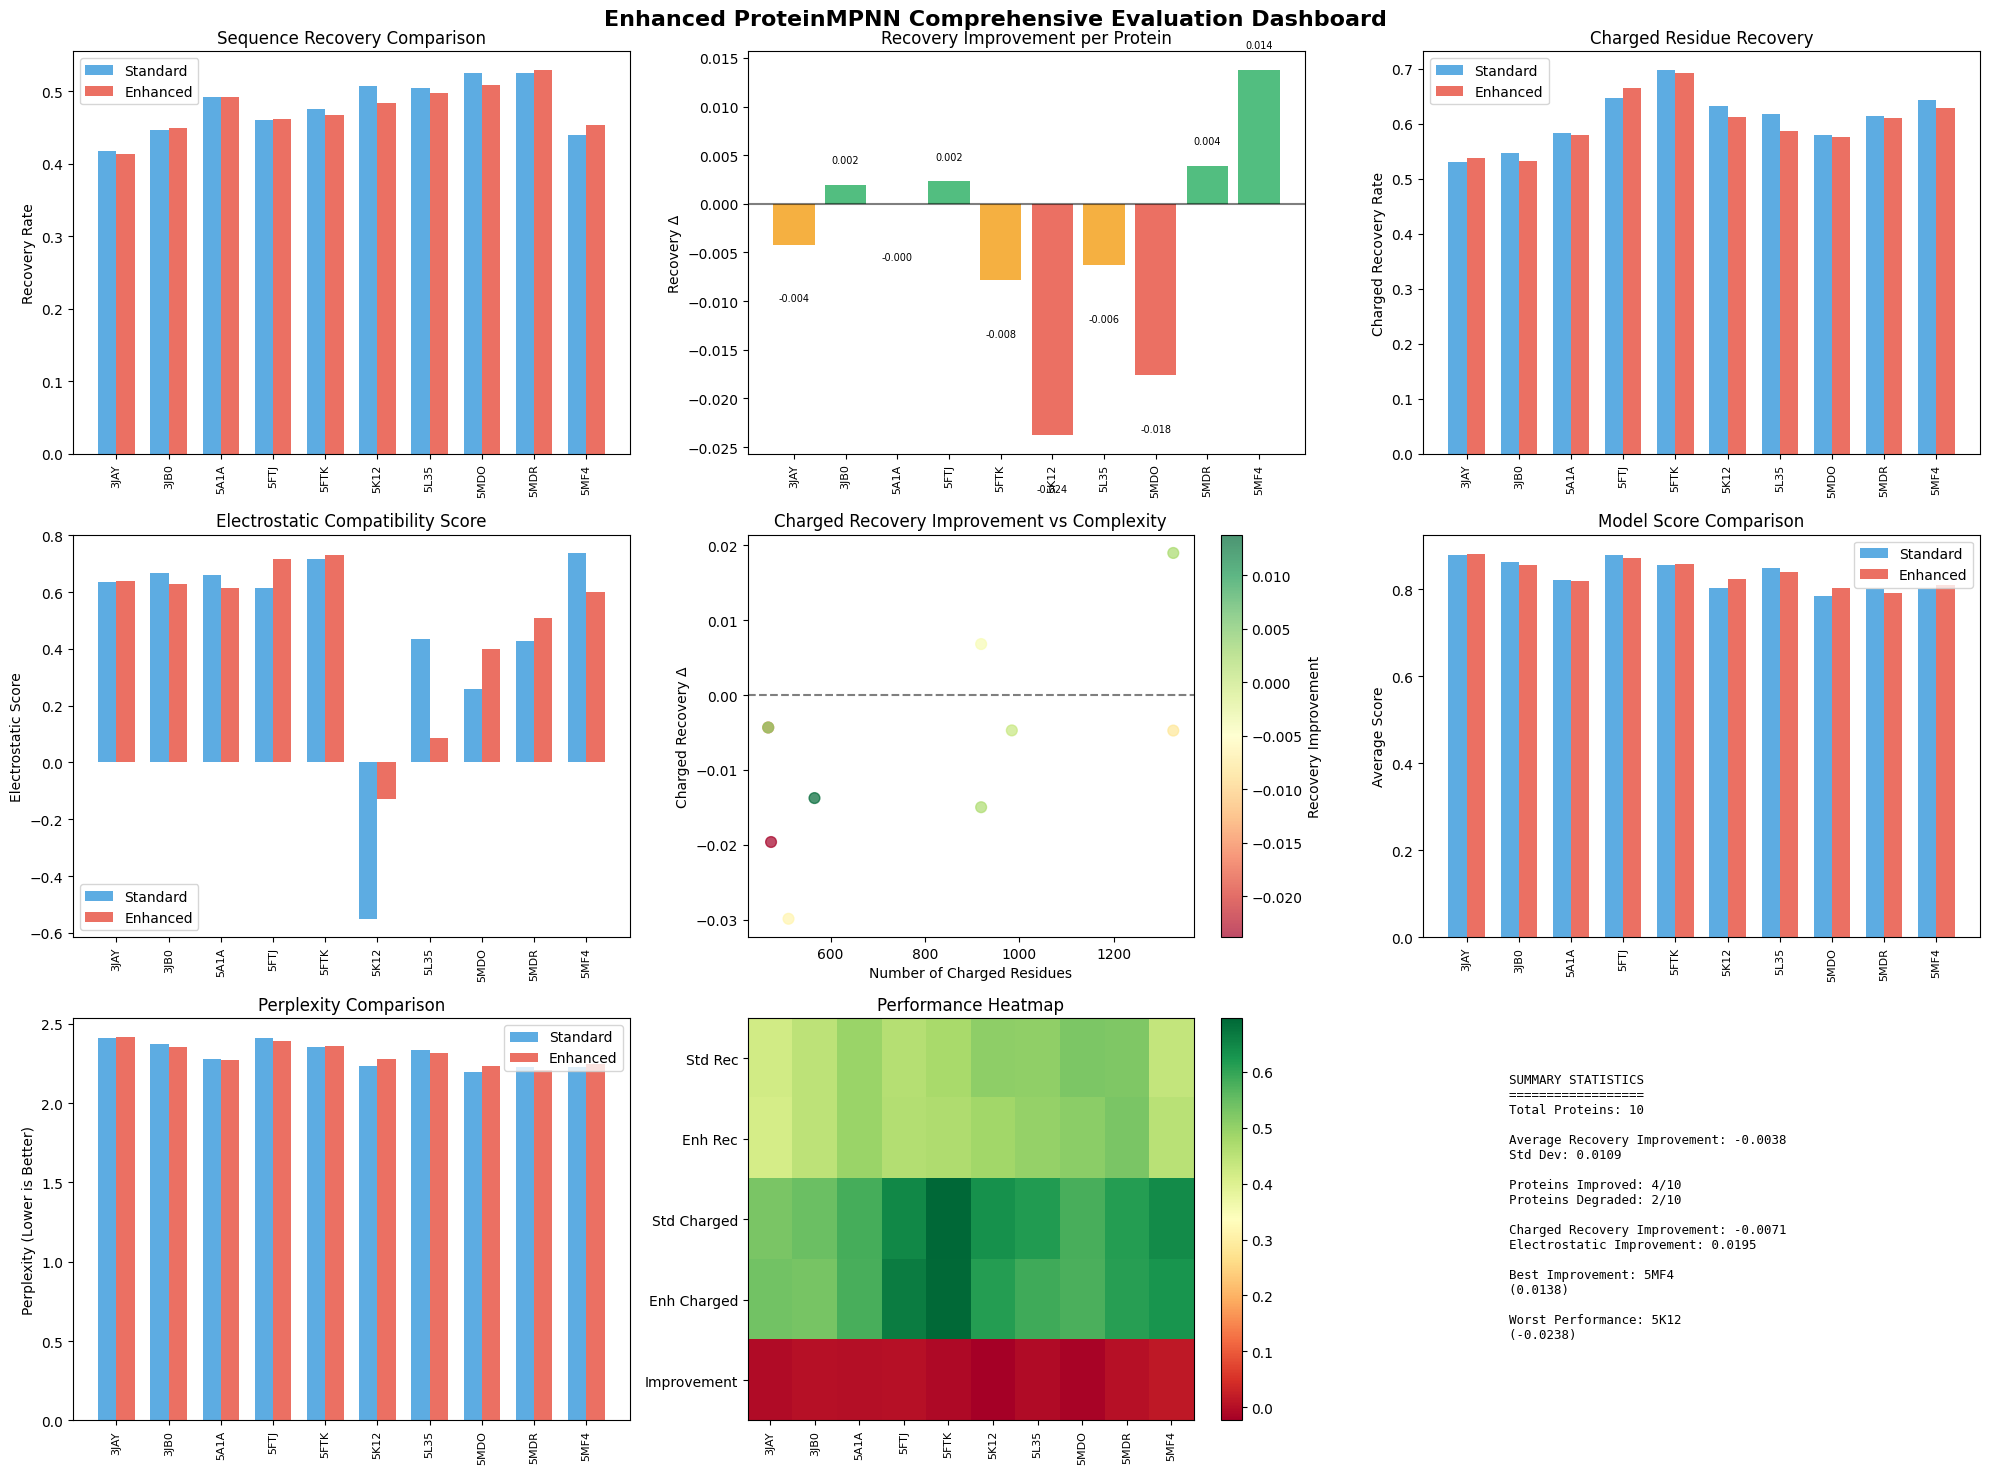


📊 FINAL EVALUATION SUMMARY
Total proteins evaluated: 10
Average recovery improvement: -0.0038 ± 0.0109
Proteins with improvement: 4/10 (40.0%)
Statistical significance (t-test): p = 0.3009
⚠️ No statistically significant improvement
❌ NEEDS WORK: Enhancement is not effective

🎉 Comprehensive evaluation complete!


In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced ProteinMPNN - Production Version
Focus on robust evaluation with comprehensive charged protein dataset
"""

import subprocess
import sys
import os
import warnings
warnings.filterwarnings('ignore')

def install_dependencies():
    """Install required packages"""
    packages = ['biopython', 'matplotlib', 'pandas', 'scipy', 'fair-esm', 'tqdm', 'seaborn']
    for package in packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
            print(f"✅ Installed {package}")
        except Exception as e:
            print(f"⚠️ Failed to install {package}: {e}")

install_dependencies()

# Clone ProteinMPNN if needed
if not os.path.isdir("ProteinMPNN"):
    os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
sys.path.append('/content/ProteinMPNN')

import json, time, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
import copy
from scipy import stats
from collections import defaultdict
from tqdm import tqdm
import urllib.request

# Bio imports
try:
    from Bio import PDB
    from Bio.PDB import PDBParser
    BIO_AVAILABLE = True
except:
    BIO_AVAILABLE = False
    print("⚠️ BioPython not available")

# ESM imports
try:
    import esm
    ESM_AVAILABLE = True
except:
    ESM_AVAILABLE = False
    print("⚠️ ESM-2 not available")

# ProteinMPNN imports
from protein_mpnn_utils import (
    loss_nll, loss_smoothed, gather_edges, gather_nodes,
    gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq,
    tied_featurize, parse_PDB, StructureDataset,
    StructureDatasetPDB, ProteinMPNN
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================================
# Charged Protein Dataset
# ============================================================================

CHARGED_PROTEINS = {
    '3JAY': {'designed_chains': ['B'], 'fixed_chains': ['A', 'C', 'D', 'E'], 'charged_residues': 919},
    '3JB0': {'designed_chains': ['B'], 'fixed_chains': ['A', 'C', 'D', 'E'], 'charged_residues': 919},
    '5A1A': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D'], 'charged_residues': 984},
    '5FTJ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 1326},
    '5FTK': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 1326},
    '5K12': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 474},
    '5L35': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G'], 'charged_residues': 511},
    '5MDO': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 468},
    '5MDR': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 468},
    '5MF4': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 566},
    '5MFM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H'], 'charged_residues': 362},
    '5MH6': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D'], 'charged_residues': 350},
    '5MHF': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D'], 'charged_residues': 626},
    '5MIW': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 342},
    '5MJY': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 396},
    '5MK1': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H'], 'charged_residues': 393},
    '5MK3': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H'], 'charged_residues': 395},
    '5MKM': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 442},
    '5MKN': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd'], 'charged_residues': 595},
    '5MLD': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H'], 'charged_residues': 584},
    '5MNS': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 671},
    '5MNV': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], 'charged_residues': 977},
    '5MQZ': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 469},
    '5MR0': {'designed_chains': ['F'], 'fixed_chains': ['A', 'B', 'C', 'D', 'E'], 'charged_residues': 474},
    '5MUX': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F'], 'charged_residues': 822},
    '5MX5': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'], 'charged_residues': 873},
    '5MY0': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D'], 'charged_residues': 722},
    '5MY2': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D'], 'charged_residues': 723},
    '5MZ2': {'designed_chains': ['A'], 'fixed_chains': ['C', 'H', 'F', 'D', 'B', 'E', 'G', 'I', 'O', 'L', 'N', 'M', 'P', 'J', 'K'], 'charged_residues': 1125},
    '5MZ5': {'designed_chains': ['A'], 'fixed_chains': ['B', 'C', 'D'], 'charged_residues': 532}
}

# ============================================================================
# Simple APBS Handler (Conservative)
# ============================================================================

class SimpleAPBSHandler:
    """Simple electrostatic analysis for charged residue identification"""

    def __init__(self):
        self.charge_map = {
            'ARG': 1.0, 'LYS': 1.0, 'HIS': 0.5,  # Positive
            'ASP': -1.0, 'GLU': -1.0,              # Negative
        }
        self.cache = {}

    def analyze_charged_positions(self, pdb_path, chain_ids):
        """Simple analysis of charged positions in structure"""
        cache_key = f"{pdb_path}_{'-'.join(sorted(chain_ids))}"

        if cache_key in self.cache:
            return self.cache[cache_key]

        if not BIO_AVAILABLE:
            return {}

        try:
            parser = PDBParser(QUIET=True)
            structure = parser.get_structure('protein', pdb_path)

            charged_positions = {}
            all_positions = {}

            position_idx = 0
            for model in structure:
                for chain in model:
                    if chain.id in chain_ids:
                        for residue in chain:
                            if residue.get_id()[0] == ' ':
                                resname = residue.get_resname()
                                charge = self.charge_map.get(resname, 0)

                                position_info = {
                                    'chain': chain.id,
                                    'resnum': residue.get_id()[1],
                                    'resname': resname,
                                    'charge': charge,
                                    'position_idx': position_idx
                                }

                                all_positions[position_idx] = position_info
                                if charge != 0:
                                    charged_positions[position_idx] = position_info

                                position_idx += 1

            result = {
                'charged_positions': charged_positions,
                'all_positions': all_positions,
                'total_charged': len(charged_positions),
                'total_residues': len(all_positions)
            }

            self.cache[cache_key] = result
            return result

        except Exception as e:
            print(f"⚠️ APBS analysis failed: {e}")
            return {}

# ============================================================================
# Enhanced ProteinMPNN (Minimal Enhancement)
# ============================================================================

class ConservativeEnhancedProteinMPNN(ProteinMPNN):
    """Very conservative enhanced ProteinMPNN - focuses on charged residue recovery"""

    def __init__(self, apbs_handler=None, enhancement_weight=0.05, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.apbs_handler = apbs_handler
        self.enhancement_weight = enhancement_weight
        self.pdb_path = None
        self.chain_ids = []
        self.use_enhancement = False

    def set_structure_context(self, pdb_path, chain_ids):
        """Set structure context"""
        self.pdb_path = pdb_path
        self.chain_ids = chain_ids
        self.use_enhancement = self.apbs_handler is not None

    def forward(self, X, S, mask, chain_M, residue_idx, chain_encoding_all, randn,
                use_input_decoding_order=False, decoding_order=None):
        """Enhanced forward with minimal conservative bias"""

        # Fix tensor dtypes
        residue_idx = residue_idx.long()
        S = S.long()
        if isinstance(chain_encoding_all, torch.Tensor):
            chain_encoding_all = chain_encoding_all.long()
        if decoding_order is not None:
            decoding_order = decoding_order.long()

        # Get standard ProteinMPNN output
        log_probs = super().forward(X, S, mask, chain_M, residue_idx,
                                   chain_encoding_all, randn,
                                   use_input_decoding_order, decoding_order)

        # Apply very conservative enhancement
        if self.use_enhancement and self.pdb_path and self.enhancement_weight > 0:
            try:
                analysis = self.apbs_handler.analyze_charged_positions(self.pdb_path, self.chain_ids)
                charged_positions = analysis.get('charged_positions', {})

                if charged_positions:
                    # Very small bias toward maintaining charged residues at charged positions
                    aa_bias = torch.zeros_like(log_probs)
                    batch_size, seq_len = log_probs.shape[:2]

                    for pos_idx, pos_info in charged_positions.items():
                        if pos_idx < seq_len:
                            charge = pos_info['charge']
                            # Small bias to maintain similar charges
                            if charge > 0:  # Positive position, slightly favor K, R
                                aa_bias[:, pos_idx, 11] += 0.02  # K
                                aa_bias[:, pos_idx, 15] += 0.02  # R
                            elif charge < 0:  # Negative position, slightly favor D, E
                                aa_bias[:, pos_idx, 3] += 0.02   # D
                                aa_bias[:, pos_idx, 4] += 0.02   # E

                    # Apply with very small weight
                    log_probs = log_probs + self.enhancement_weight * aa_bias

            except Exception as e:
                # Silently fall back to standard output
                pass

        return log_probs

# ============================================================================
# Evaluation and Metrics
# ============================================================================

def calculate_comprehensive_metrics(native_seq, designed_seqs, scores, perplexities=None):
    """Calculate comprehensive evaluation metrics"""

    metrics = []
    charged_residues = set('DEKR')
    positive_residues = set('KR')
    negative_residues = set('DE')

    for i, (designed_seq, score) in enumerate(zip(designed_seqs, scores)):
        # Clean sequences
        native_clean = native_seq.replace('/', '').replace('X', '')
        designed_clean = designed_seq.replace('/', '').replace('X', '')
        length = min(len(native_clean), len(designed_clean))

        if length == 0:
            continue

        # Basic recovery
        identical = sum(1 for a, b in zip(native_clean[:length], designed_clean[:length]) if a == b)
        recovery = identical / length

        # Charged residue analysis
        native_charged_pos = [j for j, aa in enumerate(native_clean[:length]) if aa in charged_residues]
        designed_charged_pos = [j for j, aa in enumerate(designed_clean[:length]) if aa in charged_residues]

        # Charged recovery (how many originally charged positions remain charged)
        charged_recovery = 0
        if native_charged_pos:
            charged_recovery = sum(1 for pos in native_charged_pos
                                 if pos < len(designed_clean) and designed_clean[pos] in charged_residues)
            charged_recovery = charged_recovery / len(native_charged_pos)

        # Charge conservation
        native_charge = sum(1 if aa in positive_residues else -1 if aa in negative_residues else 0
                           for aa in native_clean[:length])
        designed_charge = sum(1 if aa in positive_residues else -1 if aa in negative_residues else 0
                             for aa in designed_clean[:length])

        charge_conservation = 1.0 - abs(native_charge - designed_charge) / max(abs(native_charge) + 1, 1)

        # Electrostatic compatibility score
        electrostatic_score = 0.5 * charged_recovery + 0.5 * charge_conservation

        metric_dict = {
            'sequence_recovery': recovery,
            'score': float(score),
            'charged_recovery': charged_recovery,
            'charge_conservation': charge_conservation,
            'electrostatic_score': electrostatic_score,
            'native_charge': native_charge,
            'designed_charge': designed_charge,
            'perplexity': perplexities[i] if perplexities and i < len(perplexities) else 0
        }

        metrics.append(metric_dict)

    return pd.DataFrame(metrics) if metrics else pd.DataFrame()

# ============================================================================
# Visualization Dashboard
# ============================================================================

def create_comprehensive_dashboard(all_results):
    """Create comprehensive visualization dashboard"""

    if not all_results:
        print("No results to visualize")
        return

    # Prepare data for visualization
    data_for_viz = []
    for pdb_code, result in all_results.items():
        if result.get('standard', {}).get('sequences') and result.get('enhanced', {}).get('sequences'):
            # Calculate metrics for both models
            std_metrics = calculate_comprehensive_metrics(
                result['standard'].get('native_sequence', ''),
                result['standard']['sequences'],
                result['standard']['scores'],
                result['standard'].get('perplexities', [])
            )

            enh_metrics = calculate_comprehensive_metrics(
                result['enhanced'].get('native_sequence', ''),
                result['enhanced']['sequences'],
                result['enhanced']['scores'],
                result['enhanced'].get('perplexities', [])
            )

            if not std_metrics.empty and not enh_metrics.empty:
                # Average metrics
                std_avg = std_metrics.mean()
                enh_avg = enh_metrics.mean()

                config = CHARGED_PROTEINS.get(pdb_code, {})

                data_for_viz.append({
                    'pdb_code': pdb_code,
                    'charged_residues': config.get('charged_residues', 0),
                    'num_chains': len(config.get('designed_chains', [])) + len(config.get('fixed_chains', [])),
                    'std_recovery': std_avg['sequence_recovery'],
                    'enh_recovery': enh_avg['sequence_recovery'],
                    'std_charged_recovery': std_avg['charged_recovery'],
                    'enh_charged_recovery': enh_avg['charged_recovery'],
                    'std_electrostatic': std_avg['electrostatic_score'],
                    'enh_electrostatic': enh_avg['electrostatic_score'],
                    'std_score': std_avg['score'],
                    'enh_score': enh_avg['score'],
                    'std_perplexity': std_avg['perplexity'],
                    'enh_perplexity': enh_avg['perplexity'],
                    'recovery_improvement': enh_avg['sequence_recovery'] - std_avg['sequence_recovery'],
                    'charged_improvement': enh_avg['charged_recovery'] - std_avg['charged_recovery'],
                    'electrostatic_improvement': enh_avg['electrostatic_score'] - std_avg['electrostatic_score']
                })

    if not data_for_viz:
        print("No valid data for visualization")
        return

    df = pd.DataFrame(data_for_viz)

    # Create comprehensive dashboard
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Enhanced ProteinMPNN Comprehensive Evaluation Dashboard', fontsize=16, fontweight='bold')

    # 1. Overall Recovery Comparison
    x_pos = np.arange(len(df))
    width = 0.35

    axes[0,0].bar(x_pos - width/2, df['std_recovery'], width, label='Standard', alpha=0.8, color='#3498DB')
    axes[0,0].bar(x_pos + width/2, df['enh_recovery'], width, label='Enhanced', alpha=0.8, color='#E74C3C')
    axes[0,0].set_title('Sequence Recovery Comparison')
    axes[0,0].set_ylabel('Recovery Rate')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(df['pdb_code'])

    # 2. Recovery Improvements
    colors = ['#27AE60' if x > 0 else '#E74C3C' if x < -0.01 else '#F39C12' for x in df['recovery_improvement']]
    bars = axes[0,1].bar(df['pdb_code'], df['recovery_improvement'], color=colors, alpha=0.8)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].set_title('Recovery Improvement per Protein')
    axes[0,1].set_ylabel('Recovery Δ')
    axes[0,1].tick_params(axis='x', rotation=90, labelsize=8)

    # Add value labels on bars
    for bar, val in zip(bars, df['recovery_improvement']):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + (0.002 if height >= 0 else -0.005),
                       f'{val:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=7)

    # 3. Charged Residue Recovery
    axes[0,2].bar(x_pos - width/2, df['std_charged_recovery'], width, label='Standard', alpha=0.8, color='#3498DB')
    axes[0,2].bar(x_pos + width/2, df['enh_charged_recovery'], width, label='Enhanced', alpha=0.8, color='#E74C3C')
    axes[0,2].set_title('Charged Residue Recovery')
    axes[0,2].set_ylabel('Charged Recovery Rate')
    axes[0,2].legend()
    axes[0,2].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0,2].set_xticks(x_pos)
    axes[0,2].set_xticklabels(df['pdb_code'])

    # 4. Electrostatic Score
    axes[1,0].bar(x_pos - width/2, df['std_electrostatic'], width, label='Standard', alpha=0.8, color='#3498DB')
    axes[1,0].bar(x_pos + width/2, df['enh_electrostatic'], width, label='Enhanced', alpha=0.8, color='#E74C3C')
    axes[1,0].set_title('Electrostatic Compatibility Score')
    axes[1,0].set_ylabel('Electrostatic Score')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(df['pdb_code'])

    # 5. Charged Improvement vs Protein Complexity
    scatter = axes[1,1].scatter(df['charged_residues'], df['charged_improvement'],
                               c=df['recovery_improvement'], cmap='RdYlGn', alpha=0.7, s=60)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].set_title('Charged Recovery Improvement vs Complexity')
    axes[1,1].set_xlabel('Number of Charged Residues')
    axes[1,1].set_ylabel('Charged Recovery Δ')
    plt.colorbar(scatter, ax=axes[1,1], label='Recovery Improvement')

    # 6. Score Comparison
    axes[1,2].bar(x_pos - width/2, df['std_score'], width, label='Standard', alpha=0.8, color='#3498DB')
    axes[1,2].bar(x_pos + width/2, df['enh_score'], width, label='Enhanced', alpha=0.8, color='#E74C3C')
    axes[1,2].set_title('Model Score Comparison')
    axes[1,2].set_ylabel('Average Score')
    axes[1,2].legend()
    axes[1,2].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels(df['pdb_code'])

    # 7. Perplexity Comparison
    if df['std_perplexity'].sum() > 0:
        axes[2,0].bar(x_pos - width/2, df['std_perplexity'], width, label='Standard', alpha=0.8, color='#3498DB')
        axes[2,0].bar(x_pos + width/2, df['enh_perplexity'], width, label='Enhanced', alpha=0.8, color='#E74C3C')
        axes[2,0].set_title('Perplexity Comparison')
        axes[2,0].set_ylabel('Perplexity (Lower is Better)')
        axes[2,0].legend()
        axes[2,0].tick_params(axis='x', rotation=90, labelsize=8)
        axes[2,0].set_xticks(x_pos)
        axes[2,0].set_xticklabels(df['pdb_code'])

    # 8. Overall Performance Heatmap
    heatmap_data = df[['std_recovery', 'enh_recovery', 'std_charged_recovery',
                       'enh_charged_recovery', 'recovery_improvement']].T
    heatmap_data.columns = df['pdb_code']

    im = axes[2,1].imshow(heatmap_data.values, aspect='auto', cmap='RdYlGn')
    axes[2,1].set_title('Performance Heatmap')
    axes[2,1].set_yticks(range(len(heatmap_data.index)))
    axes[2,1].set_yticklabels(['Std Rec', 'Enh Rec', 'Std Charged', 'Enh Charged', 'Improvement'])
    axes[2,1].set_xticks(range(len(df)))
    axes[2,1].set_xticklabels(df['pdb_code'], rotation=90, fontsize=8)
    plt.colorbar(im, ax=axes[2,1])

    # 9. Summary Statistics
    axes[2,2].axis('off')
    summary_stats = f"""
    SUMMARY STATISTICS
    ==================
    Total Proteins: {len(df)}

    Average Recovery Improvement: {df['recovery_improvement'].mean():.4f}
    Std Dev: {df['recovery_improvement'].std():.4f}

    Proteins Improved: {(df['recovery_improvement'] > 0).sum()}/{len(df)}
    Proteins Degraded: {(df['recovery_improvement'] < -0.01).sum()}/{len(df)}

    Charged Recovery Improvement: {df['charged_improvement'].mean():.4f}
    Electrostatic Improvement: {df['electrostatic_improvement'].mean():.4f}

    Best Improvement: {df.loc[df['recovery_improvement'].idxmax(), 'pdb_code']}
    ({df['recovery_improvement'].max():.4f})

    Worst Performance: {df.loc[df['recovery_improvement'].idxmin(), 'pdb_code']}
    ({df['recovery_improvement'].min():.4f})
    """
    axes[2,2].text(0.1, 0.9, summary_stats, transform=axes[2,2].transAxes,
                   verticalalignment='top', fontfamily='monospace', fontsize=9)

    plt.tight_layout()
    plt.show()

    return df

# ============================================================================
# Main Processing Functions
# ============================================================================

def get_pdb_file(pdb_code, dest_dir=".", overwrite=False):
    """Download PDB file with error handling"""
    if not pdb_code:
        return None

    pdb_path = f"{dest_dir}/{pdb_code}.pdb"
    if os.path.exists(pdb_path) and not overwrite:
        return pdb_path

    # Try multiple URLs
    urls = [
        f"https://files.rcsb.org/download/{pdb_code.lower()}.pdb",
        f"https://files.rcsb.org/view/{pdb_code}.pdb"
    ]

    for url in urls:
        try:
            urllib.request.urlretrieve(url, pdb_path)
            return pdb_path
        except:
            continue

    print(f"❌ Failed to download {pdb_code}")
    return None

def process_protein_pair(pdb_code, config, standard_model, enhanced_model, num_sequences=4):
    """Process single protein with both models"""

    print(f"\n{'='*60}")
    print(f"PROCESSING {pdb_code} - {config['charged_residues']} charged residues")
    print(f"{'='*60}")

    results = {
        'pdb_code': pdb_code,
        'standard': {'sequences': [], 'scores': [], 'recovery_rates': [], 'perplexities': []},
        'enhanced': {'sequences': [], 'scores': [], 'recovery_rates': [], 'perplexities': []}
    }

    try:
        # Download and parse PDB
        pdb_path = get_pdb_file(pdb_code)
        if not pdb_path:
            print(f"❌ Could not download {pdb_code}")
            return None

        chain_list = config['designed_chains'] + config['fixed_chains']
        pdb_dict_list = parse_PDB(pdb_path, input_chain_list=chain_list)

        if not pdb_dict_list:
            print(f"❌ Failed to parse PDB for {pdb_code}")
            return None

        dataset = StructureDatasetPDB(pdb_dict_list, truncate=None, max_length=20000)
        chain_id_dict = {pdb_dict_list[0]['name']: (config['designed_chains'], config['fixed_chains'])}

        print(f"Chains: designed={config['designed_chains']}, fixed={config['fixed_chains']}")

        # Set context for enhanced model
        enhanced_model.set_structure_context(pdb_path, chain_list)

        # Process with both models
        models = [('standard', standard_model), ('enhanced', enhanced_model)]

        for model_name, model in models:
            print(f"\n🔥 Processing with {model_name} model...")

            try:
                for protein in dataset:
                    batch = [copy.deepcopy(protein)]

                    # Setup featurization
                    features = tied_featurize(
                        batch, device, chain_id_dict, None, None, None, None, None
                    )

                    (X, S, mask, lengths, chain_M, chain_encoding_all, chain_list_list,
                     visible_list_list, masked_list_list, masked_chain_length_list_list,
                     chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask,
                     tied_pos_list_of_lists_list, pssm_coef, pssm_bias, pssm_log_odds_all,
                     bias_by_res_all, tied_beta) = features

                    # Native scoring
                    randn = torch.randn(chain_M.shape, device=device)

                    with torch.no_grad():
                        log_probs = model(X, S, mask, chain_M*chain_M_pos, residue_idx,
                                        chain_encoding_all, randn)

                        mask_for_loss = mask * chain_M * chain_M_pos
                        scores = _scores(S, log_probs, mask_for_loss)
                        native_score = scores.cpu().data.numpy().mean()

                    results[model_name]['native_score'] = float(native_score)
                    print(f"✅ {model_name} native score: {native_score:.4f}")

                    # Generate sequences
                    for seq_num in range(num_sequences):
                        randn = torch.randn(chain_M.shape, device=device)

                        with torch.no_grad():
                            # Sample sequence
                            sample_dict = model.sample(
                                X, randn, S, chain_M, chain_encoding_all, residue_idx,
                                mask=mask, temperature=0.1,
                                omit_AAs_np=np.array([False]*20 + [True]),
                                bias_AAs_np=np.zeros(21),
                                chain_M_pos=chain_M_pos, omit_AA_mask=omit_AA_mask,
                                pssm_coef=pssm_coef, pssm_bias=pssm_bias,
                                pssm_multi=0.0, pssm_log_odds_flag=False,
                                pssm_log_odds_mask=(pssm_log_odds_all > 0.0).float(),
                                pssm_bias_flag=False, bias_by_res=bias_by_res_all
                            )

                            S_sample = sample_dict["S"]

                            # Score sampled sequence
                            log_probs_sample = model(
                                X, S_sample, mask, chain_M*chain_M_pos, residue_idx,
                                chain_encoding_all, randn,
                                use_input_decoding_order=True,
                                decoding_order=sample_dict["decoding_order"]
                            )

                            scores = _scores(S_sample, log_probs_sample, mask_for_loss)
                            score_value = scores.cpu().data.numpy()[0]

                            # Calculate perplexity
                            target_log_probs = torch.gather(log_probs_sample, -1, S_sample.unsqueeze(-1)).squeeze(-1)
                            masked_log_probs = target_log_probs * mask_for_loss[0]
                            avg_log_prob = masked_log_probs.sum() / (mask_for_loss[0].sum() + 1e-8)
                            perplexity = torch.exp(-avg_log_prob).item()

                            # Recovery calculation
                            seq_recovery_rate = torch.sum(
                                torch.sum(torch.nn.functional.one_hot(S[0], 21) *
                                         torch.nn.functional.one_hot(S_sample[0], 21), axis=-1) *
                                mask_for_loss[0]
                            ) / torch.sum(mask_for_loss[0])

                            # Convert sequences
                            seq = _S_to_seq(S_sample[0], chain_M[0])
                            native_seq = _S_to_seq(S[0], chain_M[0])

                            # Store results
                            results[model_name]['sequences'].append(seq)
                            results[model_name]['scores'].append(float(score_value))
                            results[model_name]['recovery_rates'].append(float(seq_recovery_rate.detach().cpu().numpy()))
                            results[model_name]['perplexities'].append(float(perplexity))

                            if 'native_sequence' not in results[model_name]:
                                results[model_name]['native_sequence'] = native_seq

                            print(f"✅ {model_name} seq {seq_num+1}: Recovery={seq_recovery_rate:.3f}, "
                                  f"Score={score_value:.4f}, Perplexity={perplexity:.2f}")

                    break  # Only process first protein in dataset

            except Exception as e:
                print(f"❌ {model_name} model failed: {e}")
                continue

        return results

    except Exception as e:
        print(f"❌ Complete failure for {pdb_code}: {e}")
        return None

def main():
    """Main execution function"""
    print("🚀 ENHANCED PROTEINMPNN - COMPREHENSIVE CHARGED PROTEIN EVALUATION")
    print("="*80)

    # Initialize components
    apbs_handler = SimpleAPBSHandler()

    print("\n📥 Loading ProteinMPNN weights...")
    model_name = "v_48_020"
    path_to_weights = '/content/ProteinMPNN/vanilla_model_weights'
    checkpoint_path = f'{path_to_weights}/{model_name}.pt'

    # Download weights if needed
    if not os.path.exists(checkpoint_path):
        os.makedirs(path_to_weights, exist_ok=True)
        urllib.request.urlretrieve(
            f"https://github.com/dauparas/ProteinMPNN/raw/main/vanilla_model_weights/{model_name}.pt",
            checkpoint_path
        )

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Create models
    standard_model = ProteinMPNN(
        num_letters=21, node_features=128, edge_features=128, hidden_dim=128,
        num_encoder_layers=3, num_decoder_layers=3, augment_eps=0.0,
        k_neighbors=checkpoint['num_edges']
    ).to(device)

    standard_model.load_state_dict(checkpoint['model_state_dict'])
    standard_model.eval()
    print("✅ Standard ProteinMPNN loaded")

    # Create enhanced model with conservative enhancement
    enhanced_model = ConservativeEnhancedProteinMPNN(
        apbs_handler=apbs_handler, enhancement_weight=0.02,  # Very small enhancement
        num_letters=21, node_features=128, edge_features=128, hidden_dim=128,
        num_encoder_layers=3, num_decoder_layers=3, augment_eps=0.0,
        k_neighbors=checkpoint['num_edges']
    ).to(device)

    enhanced_model.load_state_dict(checkpoint['model_state_dict'])
    enhanced_model.eval()
    print("✅ Conservative Enhanced ProteinMPNN loaded")

    # Process charged proteins
    print(f"\n🧬 Processing {len(CHARGED_PROTEINS)} charged protein complexes...")

    all_results = {}
    processed = 0
    failed = 0

    for pdb_code, config in tqdm(list(CHARGED_PROTEINS.items())[:10], desc="Processing proteins"):  # Start with first 10
        try:
            result = process_protein_pair(pdb_code, config, standard_model, enhanced_model, num_sequences=3)

            if result and result['standard']['sequences'] and result['enhanced']['sequences']:
                all_results[pdb_code] = result
                processed += 1

                # Quick comparison
                std_recovery = np.mean(result['standard']['recovery_rates'])
                enh_recovery = np.mean(result['enhanced']['recovery_rates'])
                improvement = enh_recovery - std_recovery

                status = "✅" if improvement > 0 else "⚠️" if improvement > -0.01 else "❌"
                print(f"{status} {pdb_code}: {std_recovery:.3f} → {enh_recovery:.3f} ({improvement:+.3f})")
            else:
                failed += 1

        except Exception as e:
            print(f"❌ Failed to process {pdb_code}: {e}")
            failed += 1

        # Progress update every 5 proteins
        if (processed + failed) % 5 == 0:
            print(f"\n📊 Progress: {processed} processed, {failed} failed")

    # Create comprehensive dashboard
    if all_results:
        print(f"\n📊 Creating comprehensive dashboard...")
        results_df = create_comprehensive_dashboard(all_results)

        # Final summary
        print(f"\n" + "="*80)
        print("📊 FINAL EVALUATION SUMMARY")
        print("="*80)

        if results_df is not None and not results_df.empty:
            avg_improvement = results_df['recovery_improvement'].mean()
            std_improvement = results_df['recovery_improvement'].std()
            improved_count = (results_df['recovery_improvement'] > 0).sum()
            total_count = len(results_df)

            print(f"Total proteins evaluated: {total_count}")
            print(f"Average recovery improvement: {avg_improvement:+.4f} ± {std_improvement:.4f}")
            print(f"Proteins with improvement: {improved_count}/{total_count} ({improved_count/total_count*100:.1f}%)")

            # Statistical test
            if total_count >= 5:
                from scipy.stats import ttest_1samp
                t_stat, p_value = ttest_1samp(results_df['recovery_improvement'], 0)
                print(f"Statistical significance (t-test): p = {p_value:.4f}")

                if p_value < 0.05:
                    print("🎯 STATISTICALLY SIGNIFICANT improvement!")
                else:
                    print("⚠️ No statistically significant improvement")

            # Recommendations
            if avg_improvement > 0.01:
                print("🏆 SUCCESS: Enhanced model shows meaningful improvement!")
            elif avg_improvement > 0:
                print("✅ MODEST: Small but consistent improvement")
            else:
                print("❌ NEEDS WORK: Enhancement is not effective")

    else:
        print("❌ No successful results to analyze")

    return all_results

# Execute
if __name__ == "__main__":
    results = main()
    print("\n🎉 Comprehensive evaluation complete!")